In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from editdistance import eval as edit_distance

from simplipy import SimpliPyEngine

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.metrics import bootstrapped_metric_ci, zss_tree_edit_distance
from flash_ansr.eval.metrics.token_prediction import f1_score, precision, recall

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation', 'scaling')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
engine = SimpliPyEngine.load('dev_7-3', install=True)

In [4]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    'pysr': {'scaling_parameter': 'niter'},
    'nesymres': {'scaling_parameter': 'beam_width'},
    'v23.0-3M': {'scaling_parameter': 'choices'},
    'v23.0-20M': {'scaling_parameter': 'choices'},
    'v23.0-120M': {'scaling_parameter': 'choices'},
    # 'skeleton_pool': {'scaling_parameter': 'samples'},
    # 'brute_force': {'scaling_parameter': 'max_expressions'},
    'e2e': {'scaling_parameter': 'candidates_per_bag'},
}

In [5]:
TEST_SETS = ['v23_val', 'fastsrb'][1:]

In [6]:
models_not_found = []
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    results[model]['evaluations_list'] = {}
    found_dataset = False
    for dataset in TEST_SETS:
        try:
            evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, model, dataset))
            found_dataset = True
        except FileNotFoundError:
            print(f"{os.path.join(PATH_TO_EVALUATION_DATA, model, dataset)} not found, skipping.")
            continue

        evaluations_list = [d for d in evaluations_list if d.startswith(f'{scaling_parameter}_')]
        scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

        scaling_values_argsort = np.argsort(scaling_values)
        scaling_values = [scaling_values[i] for i in scaling_values_argsort]
        evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

        results[model]['scaling_values'] = scaling_values
        results[model]['evaluations_list'][dataset] = evaluations_list
        results[model]['results'] = {}

        print(f"{model}: Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
        for d in evaluations_list:
            print(f" - {d}")

    if not found_dataset:
        print(f"No datasets found for model {model}, removing from results.")
        models_not_found.append(model)

for model_not_found in models_not_found:
    del results[model_not_found]

pysr: Found 13 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 4096, 16384]
 - niter_00001.pkl
 - niter_00002.pkl
 - niter_00004.pkl
 - niter_00008.pkl
 - niter_00016.pkl
 - niter_00032.pkl
 - niter_00064.pkl
 - niter_00128.pkl
 - niter_00256.pkl
 - niter_00512.pkl
 - niter_01024.pkl
 - niter_04096.pkl
 - niter_16384.pkl
nesymres: Found 7 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 128]
 - beam_width_00001.pkl
 - beam_width_00002.pkl
 - beam_width_00004.pkl
 - beam_width_00008.pkl
 - beam_width_00016.pkl
 - beam_width_00032.pkl
 - beam_width_00128.pkl
v23.0-3M: Found 17 evaluations with scaling values: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 65536, 262144]
 - choices_00001.pkl
 - choices_00002.pkl
 - choices_00004.pkl
 - choices_00008.pkl
 - choices_00016.pkl
 - choices_00032.pkl
 - choices_00064.pkl
 - choices_00128.pkl
 - choices_00256.pkl
 - choices_00512.pkl
 - choices_01024.pkl
 - choices_02048.pkl
 - choices_

In [7]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for dataset in TEST_SETS:
        if dataset not in results[model]['evaluations_list']:
            continue
        for d in tqdm(results[model]['evaluations_list'][dataset], desc="Loading evaluation results"):
            for test_set in TEST_SETS:
                path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, model, test_set, d)
                if not os.path.exists(path_to_pickle):
                    print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                    continue
                with open(path_to_pickle, 'rb') as f:
                    # print(f"Loading {path_to_pickle}...")
                    try:
                        result = pickle.load(f)
                    except Exception as e:
                        print(f"Error loading {path_to_pickle}: {e}")
                        continue
                scaling_parameter_value = int(d.split('_')[-1].split('.')[0])
                if test_set not in results[model]['results']:
                    results[model]['results'][test_set] = {}
                results[model]['results'][test_set][scaling_parameter_value] = result

    print(f"{model} {list(results[model]['results'].keys())}")

Loading evaluation results: 100%|██████████| 13/13 [00:13<00:00,  1.07s/it]


pysr ['fastsrb']


Loading evaluation results: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


nesymres ['fastsrb']


Loading evaluation results: 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


v23.0-3M ['fastsrb']


Loading evaluation results: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


v23.0-20M ['fastsrb']


Loading evaluation results: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


v23.0-120M ['fastsrb']


Loading evaluation results: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

e2e ['fastsrb']


In [8]:
results['e2e']['results']['fastsrb'][4]['error'][:10]

[None, None, None, None, None, None, None, None, None, None]

In [9]:
# from collections import Counter

# counter = Counter(results['v23.0-3M']['results']['fastsrb'][2]['benchmark_eq_id'])

In [10]:
# counter.most_common(10)

In [11]:
# Sort the results[model]['results']['fastsrb'].keys() and similar ones
for model in results.keys():
    for test_set in TEST_SETS:
        if test_set in results[model]['results']:
            sorted_keys = sorted(results[model]['results'][test_set].keys())
            results[model]['results'][test_set] = {k: results[model]['results'][test_set][k] for k in sorted_keys}

In [12]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'skeleton': [],
    'skeleton_simplified': [],
    'expression': [],
    'variables': [],
    'variable_names': [],
    'complexity': np.nan,
    'placeholder_reason': None,
    'benchmark_metadata': {},
    'ground_truth_infix': [],
    'ground_truth_prefix': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_expression': [],
    'predicted_expression_prefix': [],
    'predicted_skeleton_prefix': [],
    'predicted_skeleton_prefix_raw': [],
    'predicted_constants': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,

    'f1_score': 0.0,
    'skeleton_length': np.inf,
    'expression_length': np.inf,
    'predicted_skeleton_prefix_length': np.inf,
    'fvu_fit': np.inf,
    'fvu_val': np.inf,
    'log10_fvu_fit': np.inf,
    'log10_fvu_val': np.inf,
    'only_approx_fvu_fit': np.inf,
    'only_approx_fvu_val': np.inf,
    'only_approx_log10_fvu_fit': np.inf,
    'only_approx_log10_fvu_val': np.inf,
    'numeric_recovery_fit': 0.0,
    'numeric_recovery_val': 0.0,
    'n_variables': np.nan,
    'n_constants': np.inf,
    'predicted_n_constants': np.inf,
    'n_constants_delta': np.inf,
    'symbolic_recovery': 0.0,
    'skeleton_length_ratio': np.inf,
    'edit_distance': np.inf,
    'zss_edit_distance': np.inf,
    'unique_variables': np.nan,
    'predicted_unique_variables': 0,
    'f1_score_unique_variables': 0.0,
    'precision_unique_variables': 0.0,
    'recall_unique_variables': 0.0,
    'total_nestedness': np.nan,
    'predicted_total_nestedness': np.inf,
}

In [13]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = [(DEFAULT_NEGATIVES.get(metric, np.nan) if r is None else r) for r in results[model]['results'][test_set][niterations][metric]]
                    if not isinstance(DEFAULT_NEGATIVES.get(metric, np.nan), list):
                        results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [14]:
results.keys()

dict_keys(['pysr', 'nesymres', 'v23.0-3M', 'v23.0-20M', 'v23.0-120M', 'e2e'])

In [15]:
# For PySR and NeSymReS, the padding has been removed from the input data for the evaluation.
# PySR supports "variable renaming" during evaluation, but NeSymReS does not.
# For NeSymReS, this has transformed the variables from, e.g. ['x3', 'x11', 'x12'] to ['x_1', 'x_2', 'x_3']
# To compute symbolic metrics, we need to transform them back to the original variable names.

def rename_variables_nesymres(skeleton, original_variable_names, *args, **kwargs):
    if skeleton is None or original_variable_names is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x_'):
            index = int(token[2:]) - 1  # 'x_1' -> 0
            if index < len(original_variable_names):
                renamed_skeleton.append(original_variable_names[index])
            else:
                renamed_skeleton.append(token)  # fallback to original token if index out of range
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

def rename_variables_pysr(skeleton, *args, **kwargs):
    # PySR's variables start at x0, x1, while the ground truth starts at x1, x2, ...
    if skeleton is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x'):
            index = int(token[1:]) + 1  # 'x0' -> 'x1'
            renamed_skeleton.append(f'x{index}')
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

# For E2E, the variables are named as x_0, x_1, etc. We need to rename them back to x1, x2, ...
def rename_variables_e2e(skeleton, *args, **kwargs):
    if skeleton is None:
        return None
    renamed_skeleton = []
    for token in skeleton:
        if token.startswith('x_'):
            index = int(token[2:]) + 1  # 'x_0' -> 'x1'
            renamed_skeleton.append(f'x{index}')
        else:
            renamed_skeleton.append(token)
    return renamed_skeleton

for model_rename, rename_method in [('nesymres', rename_variables_nesymres), ('pysr', rename_variables_pysr), ('e2e', rename_variables_e2e)]:
    if not model_rename in results:
        continue
    for test_set in results[model_rename]['results'].keys():
        for niterations in results[model_rename]['results'][test_set].keys():
            r = results[model_rename]['results'][test_set][niterations]

            unique_variables_in_ground_truth = [
                sorted(list(set(token for token in skeleton if token.startswith('x'))), key=lambda x: int(x[1:])) if skeleton is not None else None
                for skeleton in r['skeleton']]
            
            # The raw predicted skeleton will be stored in 'predicted_skeleton_prefix_raw'
            r['predicted_skeleton_prefix_raw'] = r['predicted_skeleton_prefix'].copy()
            r['predicted_skeleton_prefix'] = [
                rename_method(predicted_skeleton_prefix, variable_names)
                for predicted_skeleton_prefix, variable_names in zip(r['predicted_skeleton_prefix_raw'], unique_variables_in_ground_truth)
            ]

In [16]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return np.inf
        return 0
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
        
    if not isinstance(y_pred, np.ndarray) and np.isnan(y_pred):
        return np.inf

    y_pred = y_pred.astype(np.float64).ravel()
    y_true = y_true.astype(np.float64).ravel()

    # Check if the ground truth is finite but the prediction is not
    if np.isfinite(y_true).all() and not np.isfinite(y_pred).all():
        return np.inf

    # Scale y_true and y_pred by the inverse of the mean squared error to avoid numerical issues
    ss_res = np.mean((y_true - y_pred) ** 2)
    if ss_res == 0:
        return 0
    scale = 1 / ss_res

    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)

    return safe_divide(ss_res, ss_tot)

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps

def total_nestedness(prefix_skeleton: list[str]) -> int:
    nestedness = 0
    current_depth = 0
    for i, token in enumerate(prefix_skeleton):
        if engine.operator_arity.get(token, 0) == 1:
            current_depth += 1
        else:
            nestedness += max(0, current_depth - 1)
            current_depth = 0

    return nestedness

for model in tqdm(results.keys()):
    for test_set in results[model]['results'].keys():
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                r = results[model]['results'][test_set][scaling_value]
                r[f'fvu_{split}'] = np.array([fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'log10_fvu_{split}'] = np.array([log10_fvu(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])
                r[f'numeric_recovery_{split}'] = np.array([is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(r[f'y{saved_split_name}'], r[f'y_pred{saved_split_name}'])])

                r[f'only_approx_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'fvu_{split}'])
                r[f'only_approx_log10_fvu_{split}'] = np.where(r[f'numeric_recovery_{split}'], -np.inf, r[f'log10_fvu_{split}'])

            r[f'skeleton_simplified'] = [
                engine.simplify(skeleton, max_pattern_length=4) if skeleton is not None else None
                for skeleton in r['skeleton']]

            r['f1_score'] = np.array([
                f1_score(np.array([predicted_skeleton_prefix]), np.array([skeleton])) if predicted_skeleton_prefix is not None else None  # Will be filled with default negatives in the cell below
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])

            r['skeleton_length'] = np.array([
                len(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['predicted_skeleton_prefix_length'] = np.array([
                len(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_variables'] = np.array([
                len(set(token for token in skeleton if token.startswith('x'))) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['n_constants'] = np.array([
                skeleton.count('<constant>') if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])
            
            r['predicted_n_constants'] = np.array([
                predicted_skeleton_prefix.count('<constant>') if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            
            r['n_constants_delta'] = np.array([
                predicted_n_constants - true_n_constants if predicted_n_constants is not None and true_n_constants is not None else None
                for predicted_n_constants, true_n_constants in zip(r['predicted_n_constants'], r['n_constants'])])

            r[f'symbolic_recovery'] = np.array([
                predicted_skeleton_prefix == skeleton if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])

            r[f'skeleton_length_ratio'] = np.array([
                safe_divide(predicted_length, true_length) if predicted_length is not None and true_length is not None else None
                for predicted_length, true_length in zip(r['predicted_skeleton_prefix_length'], r['skeleton_length'])])

            r['edit_distance'] = np.array([
                edit_distance(predicted_skeleton_prefix, skeleton) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])
            
            r['zss_edit_distance'] = np.array([
                zss_tree_edit_distance(predicted_skeleton_prefix, skeleton, engine.operator_arity) if predicted_skeleton_prefix is not None and skeleton is not None else None
                for predicted_skeleton_prefix, skeleton in zip(r['predicted_skeleton_prefix'], r['skeleton_simplified'])])
            
            r['unique_variables'] = [
                sorted(list(set(token for token in skeleton if token.startswith('x'))), key=lambda x: int(x[1:])) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']]

            r['predicted_unique_variables'] = [
                sorted(list(set(token for token in predicted_skeleton_prefix if token.startswith('x'))), key=lambda x: int(x[1:])) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']]
            
            r['f1_score_unique_variables'] = np.array([
                f1_score([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['precision_unique_variables'] = np.array([
                precision([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['recall_unique_variables'] = np.array([
                recall([predicted_unique_variables], [unique_variables]) if predicted_unique_variables is not None and unique_variables is not None else None
                for predicted_unique_variables, unique_variables in zip(r['predicted_unique_variables'], r['unique_variables'])])
            
            r['total_nestedness'] = np.array([
                total_nestedness(skeleton) if skeleton is not None else None
                for skeleton in r['skeleton_simplified']])

            r['predicted_total_nestedness'] = np.array([
                total_nestedness(predicted_skeleton_prefix) if predicted_skeleton_prefix is not None else None
                for predicted_skeleton_prefix in r['predicted_skeleton_prefix']])
            

# print(results[list(results.keys())[0]]['results']['feynman'][1]['edit_distance'][:4])

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_10375/712976652.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  y_pred = y_pred.astype(np.float64).ravel()
 33%|███▎      | 2/6 [01:01<01:51, 27.99s/it]/tmp/ipykernel_10375/712976652.py:27: RuntimeWarning: overflow encountered in square
  ss_res = np.mean((y_true - y_pred) ** 2)
100%|██████████| 6/6 [05:36<00:00, 56.12s/it]


In [17]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = [(DEFAULT_NEGATIVES.get(metric, np.nan) if r is None else r) for r in results[model]['results'][test_set][niterations][metric]]
                    if not isinstance(DEFAULT_NEGATIVES.get(metric, np.nan), list):
                        results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [18]:
# results[list(results.keys())[0]]['results']['feynman'][1]['fvu_val'].shape, results[list(results.keys())[0]]['results']['feynman'][1]['fit_time'].shape

In [19]:
def arrow_notation(objective: int = 1, lower: float | str = 0, upper: float | str = 1, lower_open: bool = False, upper_open: bool = False):
    lower_bracket = '(' if lower_open else '['
    upper_bracket = ')' if upper_open else ']'

    if lower == -np.inf:
        lower_bracket = '('
        lower = '-\\infty'
    if upper == np.inf:
        upper_bracket = ')'
        upper = '\\infty'

    try:
        float(lower)
        lower = f"{lower:.2g}" if int(float(lower)) != float(lower) else f"{int(float(lower))}"
    except:
        pass

    try:
        float(upper)
        upper = f"{upper:.2g}" if int(float(upper)) != float(upper) else f"{int(float(upper))}"
    except:
        pass

    if objective == 1:
        return f"\\uparrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    elif objective == -1:
        return f"\\downarrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    else:
        raise ValueError("Objective must be 1 (higher is better) or -1 (lower is better).")

In [20]:
def naninfmean(a):
    a = np.array(a)
    return np.nanmean(a[np.isfinite(a)])

In [21]:
# results['v23.0-20M']['results']['v23_val'].keys()

/tmp/ipykernel_10375/4267528566.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(a[np.isfinite(a)])
/home/psaegert/Projects/flash-ansr/src/flash_ansr/eval/metrics/bootstrap.py:27: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(bootstrapped_metrics)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


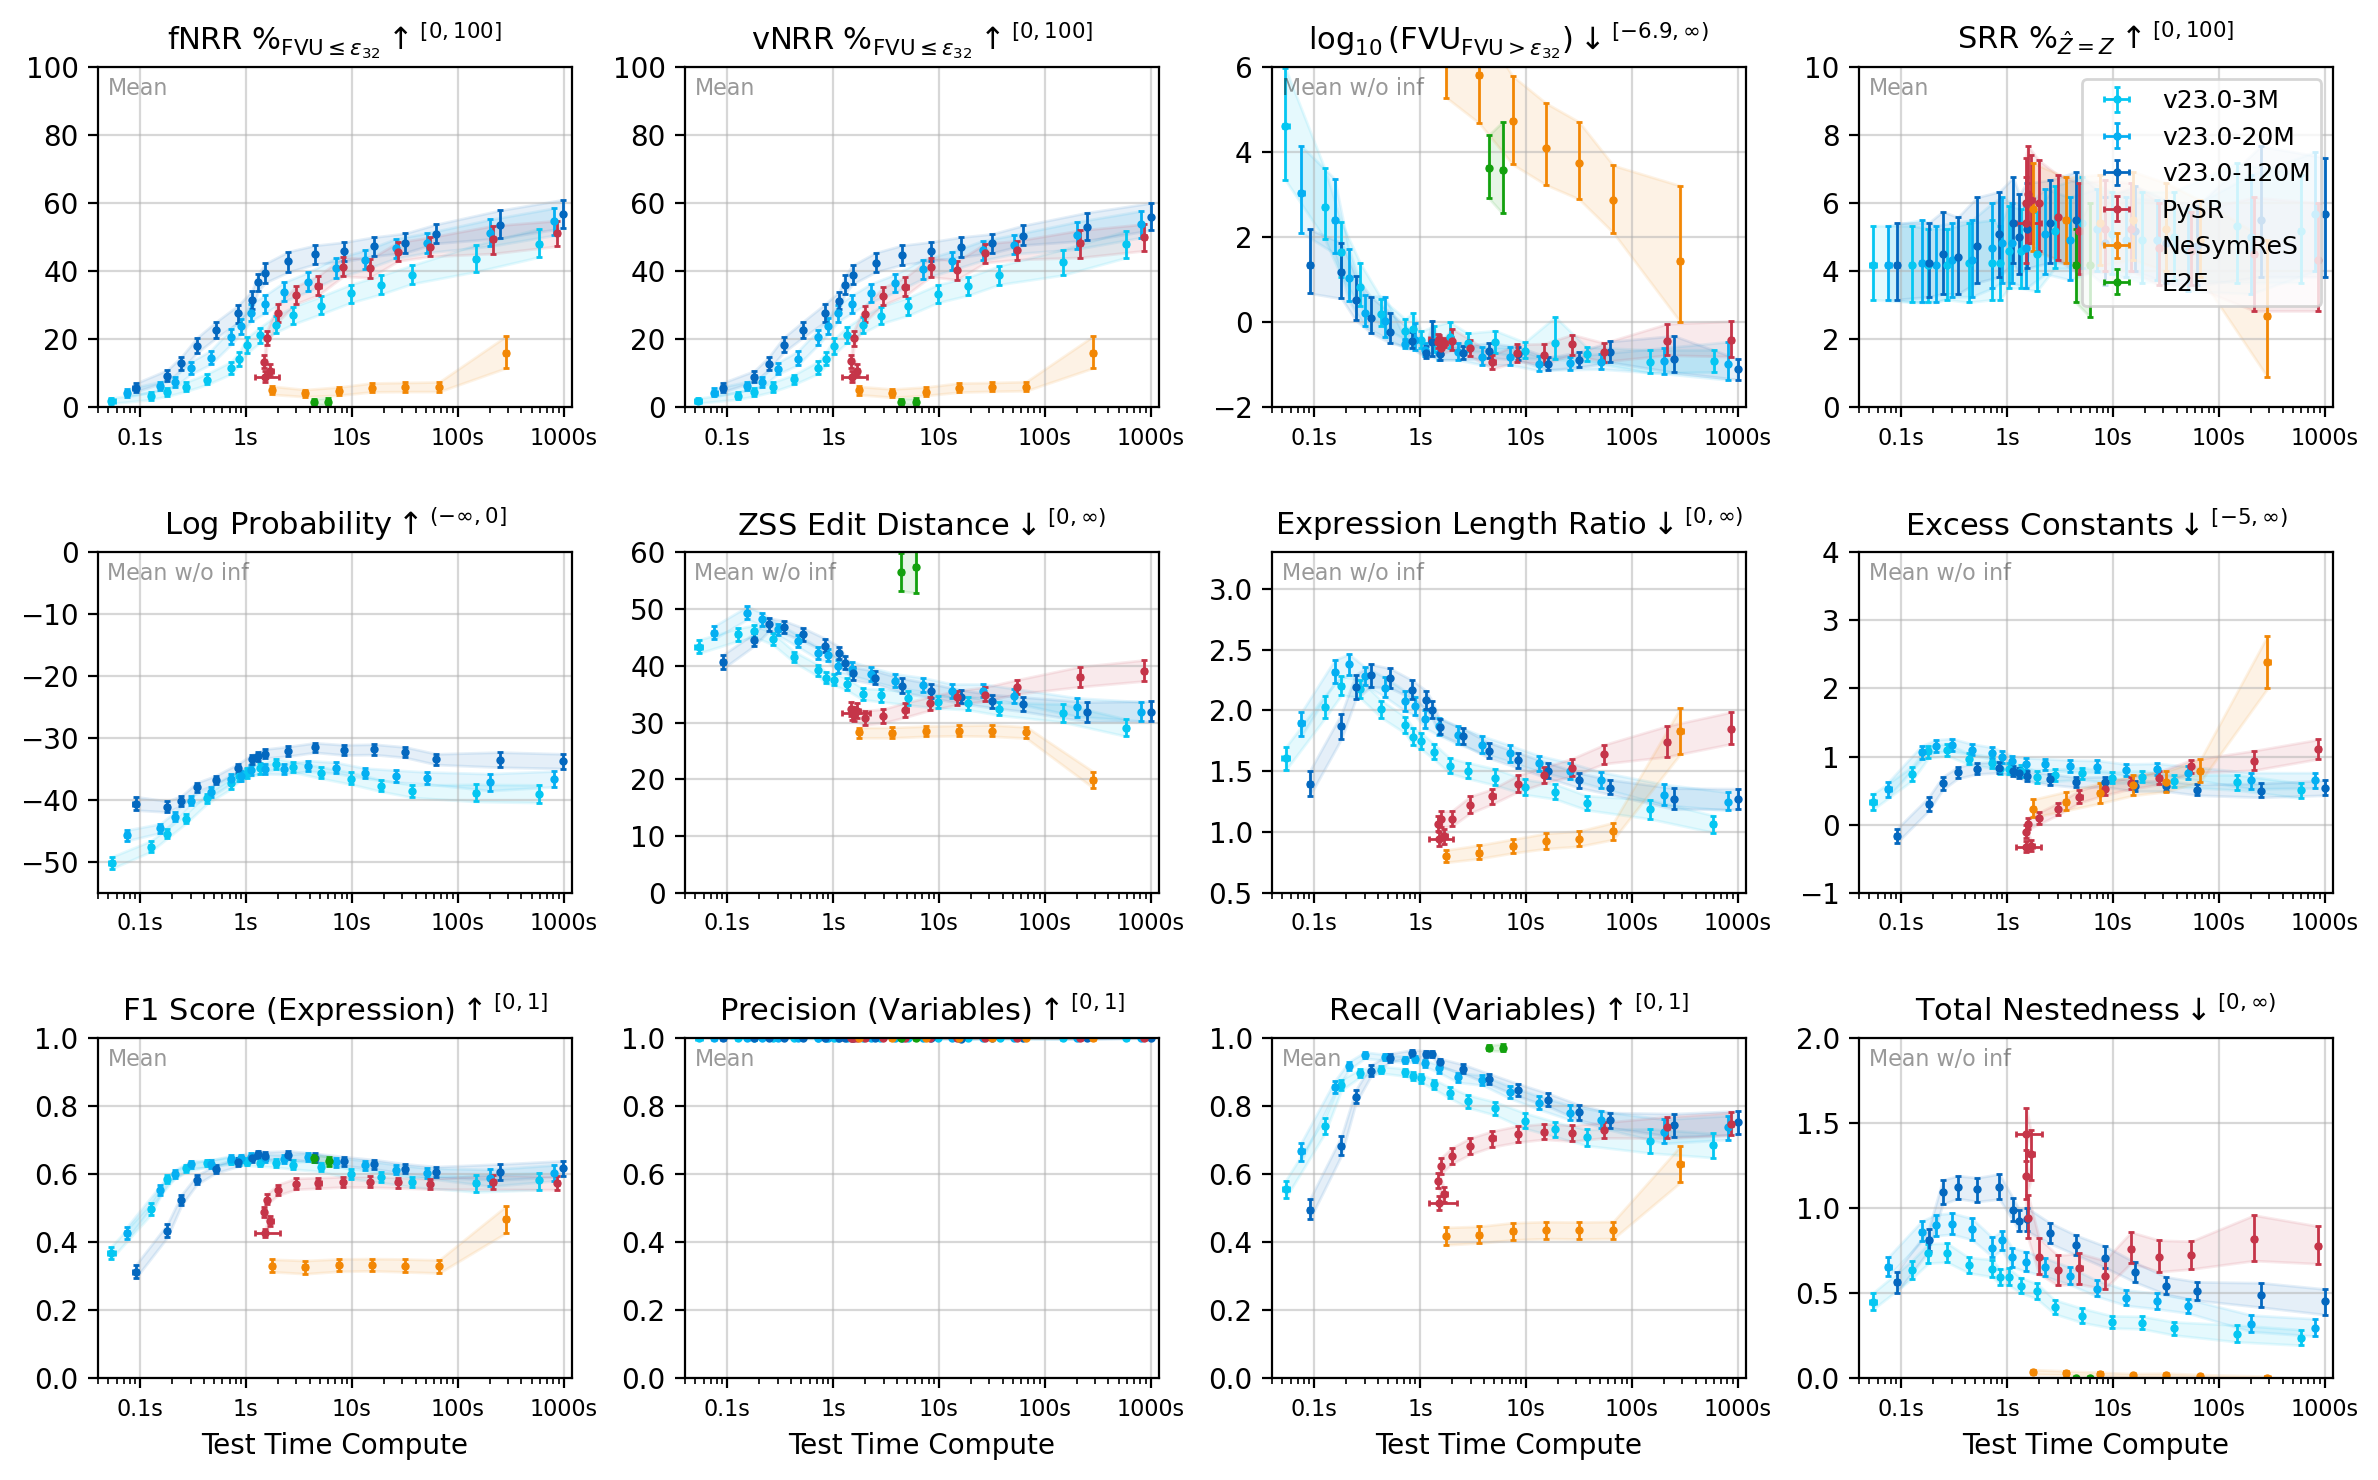

In [ ]:
first_model = list(results.keys())[0]
gt_constants = results[first_model]['results']['fastsrb'][4]['n_constants']
max_gt_constants = max(gt_constants[np.isfinite(gt_constants)])

metric_pairs = [
    (('fit_time', 'Test Time Compute', naninfmean), (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'only_approx_log10_fvu_val',
        f'$\\log_{{10}}(\mathrm{{FVU}}_{{\\mathrm{{FVU}} > \epsilon_{{32}}}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        naninfmean,
        1,
        (-2, 6)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'symbolic_recovery',
        f'SRR $\\%_{{\hat{{Z}} = Z}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 10)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'predicted_log_prob',
        f'$\mathrm{{Log\\ Probability}} {arrow_notation(objective=1, lower=-np.inf, upper=0)}$',
        naninfmean,
        1,
        (-55, 0)
    )),
    # (('fit_time', 'Test Time Compute', naninfmean), (
    #     'skeleton_length_ratio',
    #     f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
    #     naninfmean,
    #     1,
    #     (0.5, 2)
    # )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'zss_edit_distance',
        f'$\mathrm{{ZSS\\ Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 60)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 3.3)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'n_constants_delta',
        f'$\mathrm{{Excess\\ Constants}} {arrow_notation(objective=-1, lower=-max_gt_constants, upper=np.inf)}$',
        naninfmean,
        1,
        (-1, 4)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'f1_score',
        f'$\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.0, 1)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'precision_unique_variables',
        f'$\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'recall_unique_variables',
        f'$\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'predicted_total_nestedness',
        f'$\mathrm{{Total\\ Nestedness}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 2)
    )),
    # (('fit_time', 'Test Time Compute', np.nanmedian), (
    #     'prediction_success',
    #     f'$\mathrm{{Fit\\ Success}} {arrow_notation(objective=1, lower=0, upper=1)}$',
    #     naninfmean,
    #     100,
    #     (0, 100)
    # )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2', 'v23.0-3M'),
    ('v23.0-20M', 'choices', '#05AFF2', 'v23.0-20M'),
    ('v23.0-120M', 'choices', '#0468BF', 'v23.0-120M'),
    # ('v23.0-1B', 'choices', '#0339A6'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549', 'PySR'),
    ('nesymres', 'beam_width', '#F28705', 'NeSymReS'),
    # ('skeleton_pool', 'samples', "#54606C", 'Prior'),
    # ('brute_force', 'max_expressions', '#000000', 'Brute Force'),
    ('e2e', 'candidates_per_bag', "#13a10e", 'E2E'),
]

models = [m for m in models if m[0] in results.keys()]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

if len(TEST_SETS) == 1:
    test_set = TEST_SETS[0]
else:
    test_set = 'fastsrb'
    # test_set = 'v23_val'

fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)


short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

for ax_id, (ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color, model_label in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if model_name not in results or test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():
            # if len(results[model_name]['results'][test_set][n][x_metric]) < 1000:  # AHCK: Ensure benchmark is almost fully evaluated
            #     continue

            x = results[model_name]['results'][test_set][n][x_metric]
            y = results[model_name]['results'][test_set][n][y_metric]

            # For the only_approx_log10_fvu_val, we want to ignore -inf values in the CI computation (These are cases where the model found the exact solution and should be masked out)
            if y_metric == 'only_approx_log10_fvu_val':
                # print(f"n={n}: Ignoring {np.sum(y == -np.inf)} / {len(results[model_name]['results'][test_set][n][y_metric])} (-inf) values for {y_metric}")
                y = y[y != -np.inf]

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])
            
            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])
            
            # print(f"{y_metric:<30} {model_name:<15} {n:<5} nans: {np.sum(np.isnan(y)):<4} ({np.mean(np.isnan(y))*100:<5.1f}%) nonfinite: {np.sum(~np.isfinite(y)):<4} ({np.mean(~np.isfinite(y))*100:<5.1f}%)")

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label=model_label, capsize=1, color=color, elinewidth=1, markersize=4)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

        # print(x_median, y_median)

        # for i, (n, x_val, y_val, y_low) in enumerate(zip(results[model_name]['results'][test_set].keys(), x_median, y_median, y_lower)):
        #     # if i % 4 == 0:
        #     ax.annotate(short_scaling_parameters.get(n, str(n)), xy=(x_val, y_low), fontsize=4, color=color, textcoords="offset points", xytext=(0,-3), ha='center', va='top')

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=8
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log')
    ax.set_xlim(0.04, 1200)
    ax.set_xticks([0.1, 1, 10, 100, 1000])
    ax.set_xticklabels(['0.1s', '1s', '10s', '100s', '1000s'], fontsize=x_ticks_fontsize)

    ax.grid(alpha=0.5)

axes.flatten()[3].legend(fontsize=9)

# flash = plt.imread(get_path('assets', 'flash.png'))
# ax_image = fig.add_axes([0.157, 0.75, 0.05, 0.05], anchor='NE', zorder=10)
# ax_image.imshow(flash)
# ax_image.axis('off')


for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')
    
    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=0.5, h_pad=2)


# fig.suptitle(f"Test Set: {test_set.title()}", fontsize=16) 
# fig.subplots_adjust(top=0.90)

plt.savefig(get_path('results', 'test_time_compute', create=True, filename=f'test_time_compute_{test_set}.svg'), dpi=200)

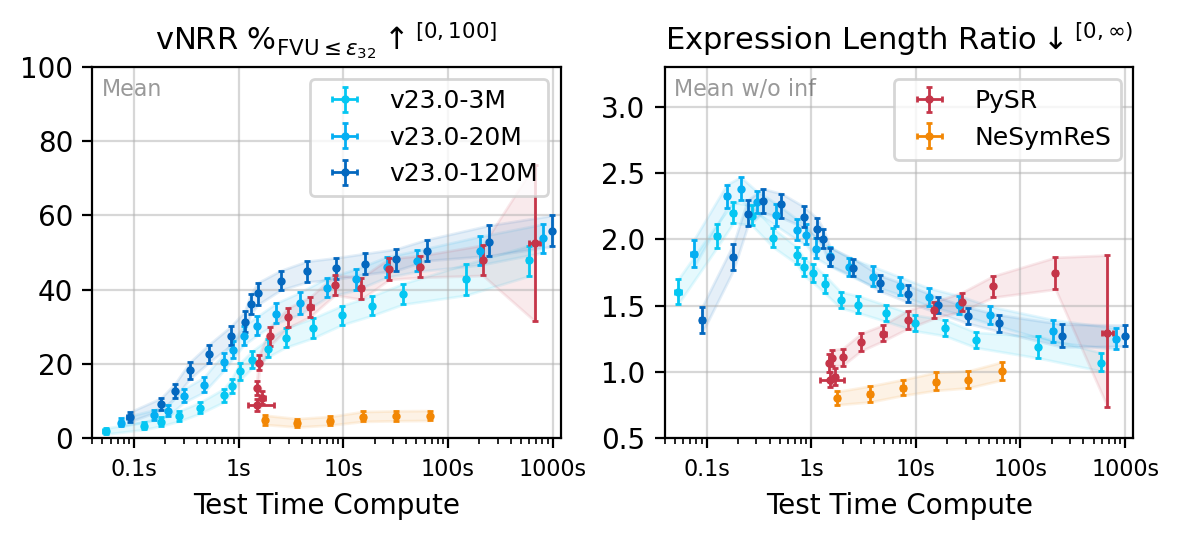

In [22]:
first_model = list(results.keys())[0]
gt_constants = results[first_model]['results']['fastsrb'][1]['n_constants']
max_gt_constants = max(gt_constants[np.isfinite(gt_constants)])

metric_pairs = [
    (('fit_time', 'Test Time Compute', naninfmean), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=100)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('fit_time', 'Test Time Compute', naninfmean), (
        'skeleton_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 3.3)
    )),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2', 'v23.0-3M'),
    ('v23.0-20M', 'choices', '#05AFF2', 'v23.0-20M'),
    ('v23.0-120M', 'choices', '#0468BF', 'v23.0-120M'),
    # ('v23.0-1B', 'choices', '#0339A6'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549', 'PySR'),
    ('nesymres', 'beam_width', '#F28705', 'NeSymReS'),
    # ('skeleton_pool', 'samples', "#54606C", 'Prior'),
    # ('brute_force', 'max_expressions', '#000000', 'Brute Force'),
]

models = [m for m in models if m[0] in results.keys()]

COLS = min(4, len(metric_pairs))
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

if len(TEST_SETS) == 1:
    test_set = TEST_SETS[0]
else:
    test_set = 'fastsrb'
    # test_set = 'v23_val'

fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.8 * ROWS), dpi=200)


short_scaling_parameters = {
    1024: '1k',
    2048: '2k',
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k',
    65536: '64k',
}

models_per_legend_list = [
    ['v23.0-3M', 'v23.0-20M', 'v23.0-120M'],
    ['pysr', 'nesymres'],
]

for ax_id, (models_per_legend, ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim))) in enumerate(zip(models_per_legend_list, axes.flatten(), metric_pairs)):
    ax: plt.Axes
    for model_name, scaling_param, color, model_label in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        if model_name not in results or test_set not in results[model_name]['results']:
            continue

        for n in results[model_name]['results'][test_set].keys():
            # if len(results[model_name]['results'][test_set][n][x_metric]) < 1000:  # AHCK: Ensure benchmark is almost fully evaluated
            #     continue

            x = results[model_name]['results'][test_set][n][x_metric]
            y = results[model_name]['results'][test_set][n][y_metric]

            # For the only_approx_log10_fvu_val, we want to ignore -inf values in the CI computation (These are cases where the model found the exact solution and should be masked out)
            if y_metric == 'only_approx_log10_fvu_val':
                # print(f"n={n}: Ignoring {np.sum(y == -np.inf)} / {len(results[model_name]['results'][test_set][n][y_metric])} (-inf) values for {y_metric}")
                y = y[y != -np.inf]

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])
            
            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])
            
            # print(f"{y_metric:<30} {model_name:<15} {n:<5} nans: {np.sum(np.isnan(y)):<4} ({np.mean(np.isnan(y))*100:<5.1f}%) nonfinite: {np.sum(~np.isfinite(y)):<4} ({np.mean(~np.isfinite(y))*100:<5.1f}%)")

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        if model_name not in models_per_legend:
            model_label_shown = None
        else:
            model_label_shown = model_label

        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label=model_label_shown, capsize=1, color=color, elinewidth=1, markersize=4)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

        # print(x_median, y_median)

        # for i, (n, x_val, y_val, y_low) in enumerate(zip(results[model_name]['results'][test_set].keys(), x_median, y_median, y_lower)):
        #     # if i % 4 == 0:
        #     ax.annotate(short_scaling_parameters.get(n, str(n)), xy=(x_val, y_low), fontsize=4, color=color, textcoords="offset points", xytext=(0,-3), ha='center', va='top')

    # Annotate if mean or median is used
    y_statistic_name = {
        np.nanmean: f'Mean',
        np.nanmedian: f'Median',
        naninfmean: f'Mean w/o inf',
    }

    ax.annotate(y_statistic_name[y_statistic], xy=(0.02, 0.97), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='top', alpha=0.4)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel(x_label)
        x_ticks_fontsize=8
    else:
        x_ticks_fontsize=8

    ax.set_title(y_label, fontsize=11)
    ax.set_xscale('log')
    ax.set_xlim(0.04, 1200)
    ax.set_xticks([0.1, 1, 10, 100, 1000])
    ax.set_xticklabels(['0.1s', '1s', '10s', '100s', '1000s'], fontsize=x_ticks_fontsize)

    ax.grid(alpha=0.5)

axes.flatten()[0].legend(fontsize=9, loc='upper right')
axes.flatten()[1].legend(fontsize=9, loc='upper right')

# flash = plt.imread(get_path('assets', 'flash.png'))
# ax_image = fig.add_axes([0.157, 0.75, 0.05, 0.05], anchor='NE', zorder=10)
# ax_image.imshow(flash)
# ax_image.axis('off')


for ax_id, ax in enumerate(axes.flatten()[len(metric_pairs):]):
    ax.axis('off')
    
    # Add an xlabel to the axis above
    if (ax_id + len(metric_pairs)) // COLS == ROWS - 1:
        axes.flatten()[len(metric_pairs) - COLS + (ax_id % COLS)].set_xlabel(x_label)

fig.tight_layout(w_pad=0.5, h_pad=2)


# fig.suptitle(f"Test Set: {test_set.title()}", fontsize=16) 
# fig.subplots_adjust(top=0.90)

plt.savefig(get_path('results', 'test_time_compute', create=True, filename=f'small_test_time_compute_{test_set}.svg'), dpi=200)

In [23]:
all_fvu_fit = np.concatenate([
    results[model]['results'][test_set][n]['fvu_fit']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])

all_fvu_val = np.concatenate([
    results[model]['results'][test_set][n]['fvu_val']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])

/tmp/ipykernel_20201/2587395620.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.hist2d(np.log10(all_fvu_fit), np.log10(all_fvu_val), bins=np.linspace(-17, 18, 128), cmap='Blues', norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=1000), zorder=2)


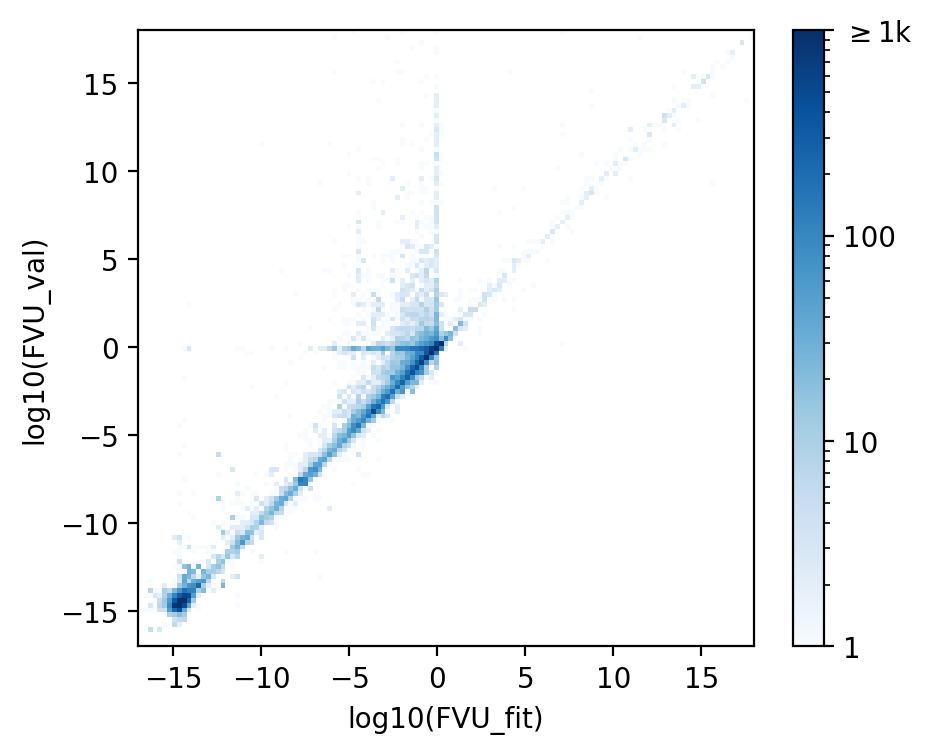

In [24]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
ax.hist2d(np.log10(all_fvu_fit), np.log10(all_fvu_val), bins=np.linspace(-17, 18, 128), cmap='Blues', norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=1000), zorder=2)
# Highlight the region of overfitting
# ax.fill_between([-17, 18], [-17, 18], [18, 18], color='red', alpha=0.05, zorder=3, label='Overfitting Region')

ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('log10(FVU_fit)')
ax.set_ylabel('log10(FVU_val)')

# Colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=1000), cmap='Blues'), ax=ax)

# Colorbar ticks
cbar.set_ticks([1, 10, 100, 1000])
cbar.set_ticklabels(['1', '10', '100', '$\geq 1$k'])

In [25]:
mask = np.where((all_fvu_val > 0.9) & (all_fvu_val < 1.1) & (all_fvu_fit < 0.01))[0]
mask

array([ 1977,  2226,  2228,  3429,  3548,  4376,  4625,  4629,  5576,
        5821,  5829,  6478,  6776,  7021,  7022,  7025,  7029,  7976,
        8221,  8222,  8225,  8229,  8328,  8348,  8878,  9179,  9185,
        9425, 10093, 10131, 10332, 10370, 10376, 10622, 10625, 10628,
       10629, 10728, 10748, 11278, 11532, 11572, 11585, 11821, 11827,
       11835, 11940, 11948, 12776, 12782, 13020, 13022, 13025, 13027,
       13128, 13881, 13976, 13979, 13982, 14221, 14225, 14229, 14348,
       14931, 15080, 15081, 15132, 15176, 15179, 15182, 15187, 15421,
       15422, 15425, 15429, 15548, 16131, 16280, 16332, 16379, 16382,
       16387, 16389, 16623, 16627, 16629, 17331, 17480, 17587, 17821,
       17825, 17829, 17835, 18385, 18390, 18392, 18394, 18511, 18513,
       18590, 18992, 19111, 19192, 20225, 20229, 20531, 20556, 21429,
       21528, 22376, 22629, 22748, 22935, 23579, 23825, 23948, 24773,
       24776, 25025, 25029, 25148, 25693, 25881, 25973, 25976, 25978,
       25985, 26229,

In [26]:
def concatenate(lists):
    return [item for sublist in lists for item in sublist]

id = mask[0]

print(concatenate([
    results[model]['results'][test_set][n]['fvu_fit']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])[id])

print(concatenate([
    results[model]['results'][test_set][n]['fvu_val']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])[id])

print(concatenate([
    results[model]['results'][test_set][n]['predicted_skeleton_prefix']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])[id])

print(np.std(concatenate([
    results[model]['results'][test_set][n]['y']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])[id]))

print(np.std(concatenate([
    results[model]['results'][test_set][n]['y_val']
    for model in ['v23.0-3M', 'v23.0-20M', 'v23.0-120M']
    for n in results[model]['results'][test_set].keys()
])[id]))

0.0016087713644258185
1.0025175635235353
['pow2', '+', '/', '/', '/', '<constant>', 'x3', 'x1', '-', 'x3', '<constant>', '/', '+', '/', '<constant>', 'x3', 'tan', '+', 'x1', '+', 'x3', 'pow2', 'x1', '<constant>']
1.331868e+06
1.9114684e+06


In [27]:
# Investigate the results for each expression in the fastsrb test set
expression_ids = results[list(results.keys())[0]]['results']['fastsrb'][1]['benchmark_eq_id'].tolist()

model = 'v23.0-120M'
scaling_parameter_value = results[model]['scaling_values'][-1]
print(f"Using scaling parameter value: {scaling_parameter_value}")
r = results[model]['results']['fastsrb'][scaling_parameter_value]

# Group the results by id and calculate summary statistics of the metrics
interesting_metrics = [
    'fit_time',
    'fvu_fit',
    'fvu_val',
    'numeric_recovery_fit',
    'numeric_recovery_val',
    'symbolic_recovery',
    'edit_distance',
    'skeleton_length_ratio',
    'n_constants_delta',
    'f1_score',
]
grouped_results = {}
for expr_id in tqdm(set(expression_ids)):
    mask = r['benchmark_eq_id'] == expr_id
    grouped_results[expr_id] = {}
    for metric in interesting_metrics:
        values = r[metric][mask]
        grouped_results[expr_id][metric] = {
            'mean': bootstrapped_metric_ci(values, np.nanmean, n=1000, interval=0.95),
            'median': bootstrapped_metric_ci(values, np.nanmedian, n=1000, interval=0.95),
        }

Using scaling parameter value: 262144


  8%|▊         | 10/120 [00:01<00:18,  5.85it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 120/120 [00:20<00:00,  5.78it/s]


In [28]:
easy_ids = [
    "I.12.1", "I.12.4", "I.12.5", "I.18.12", "I.25.13", "I.47.23", "I.14.3",
    "I.18.16", "I.43.16", "II.3.24", "II.8.31", "II.10.9", "II.13.17",
    "II.15.5", "II.27.18", "III.7.38", "III.12.43", "I.14.4", "I.26.2",
    "I.27.6", "I.30.5", "II.2.42", "II.4.23", "II.15.4", "II.27.16",
    "II.34.11", "II.34.29b", "II.38.3", "II.38.14", "III.15.27",
]
medium_ids = [
    "I.10.7", "I.12.2", "I.13.12", "I.16.6", "I.32.5", "I.43.31",
    "II.11.3", "II.34.2", "II.34.29a", "III.14.14", "III.15.14", "B8",
    "I.11.19", "I.12.11", "I.13.4", "I.15.10", "I.18.4", "I.24.6",
    "I.34.8", "I.38.12", "I.39.11", "I.43.43", "I.48.2", "II.6.11",
    "II.21.32", "II.34.2a", "III.4.32", "III.13.18", "III.15.12",
    "III.17.37", "I.8.14", "I.29.4", "I.34.10", "I.34.27", "I.39.10",
    "II.8.7", "II.37.1", "III.8.54", "III.19.51", "B18",
]
hard_ids = [
    "I.15.3x", "I.30.3", "II.6.15a", "II.11.17", "II.11.28", "II.13.23",
    "II.13.34", "II.24.17", "B1", "B6", "B12", "B16", "B17",
    "I.6.20", "I.6.20b", "I.9.18", "I.15.3t", "I.29.16", "I.34.14",
    "I.39.22", "I.44.4", "II.11.20", "II.11.27", "II.35.18",
    "III.9.52", "III.10.19", "III.21.20", "B2", "B3", "B7", "B9",
    "I.6.20a", "I.32.17", "I.37.4", "I.40.1", "I.41.16", "I.50.26",
    "II.6.15b", "II.35.21", "II.36.38", "III.4.33", "B4", "B5",
    "B10", "B11", "B13", "B14", "B15", "B19", "B20",
]

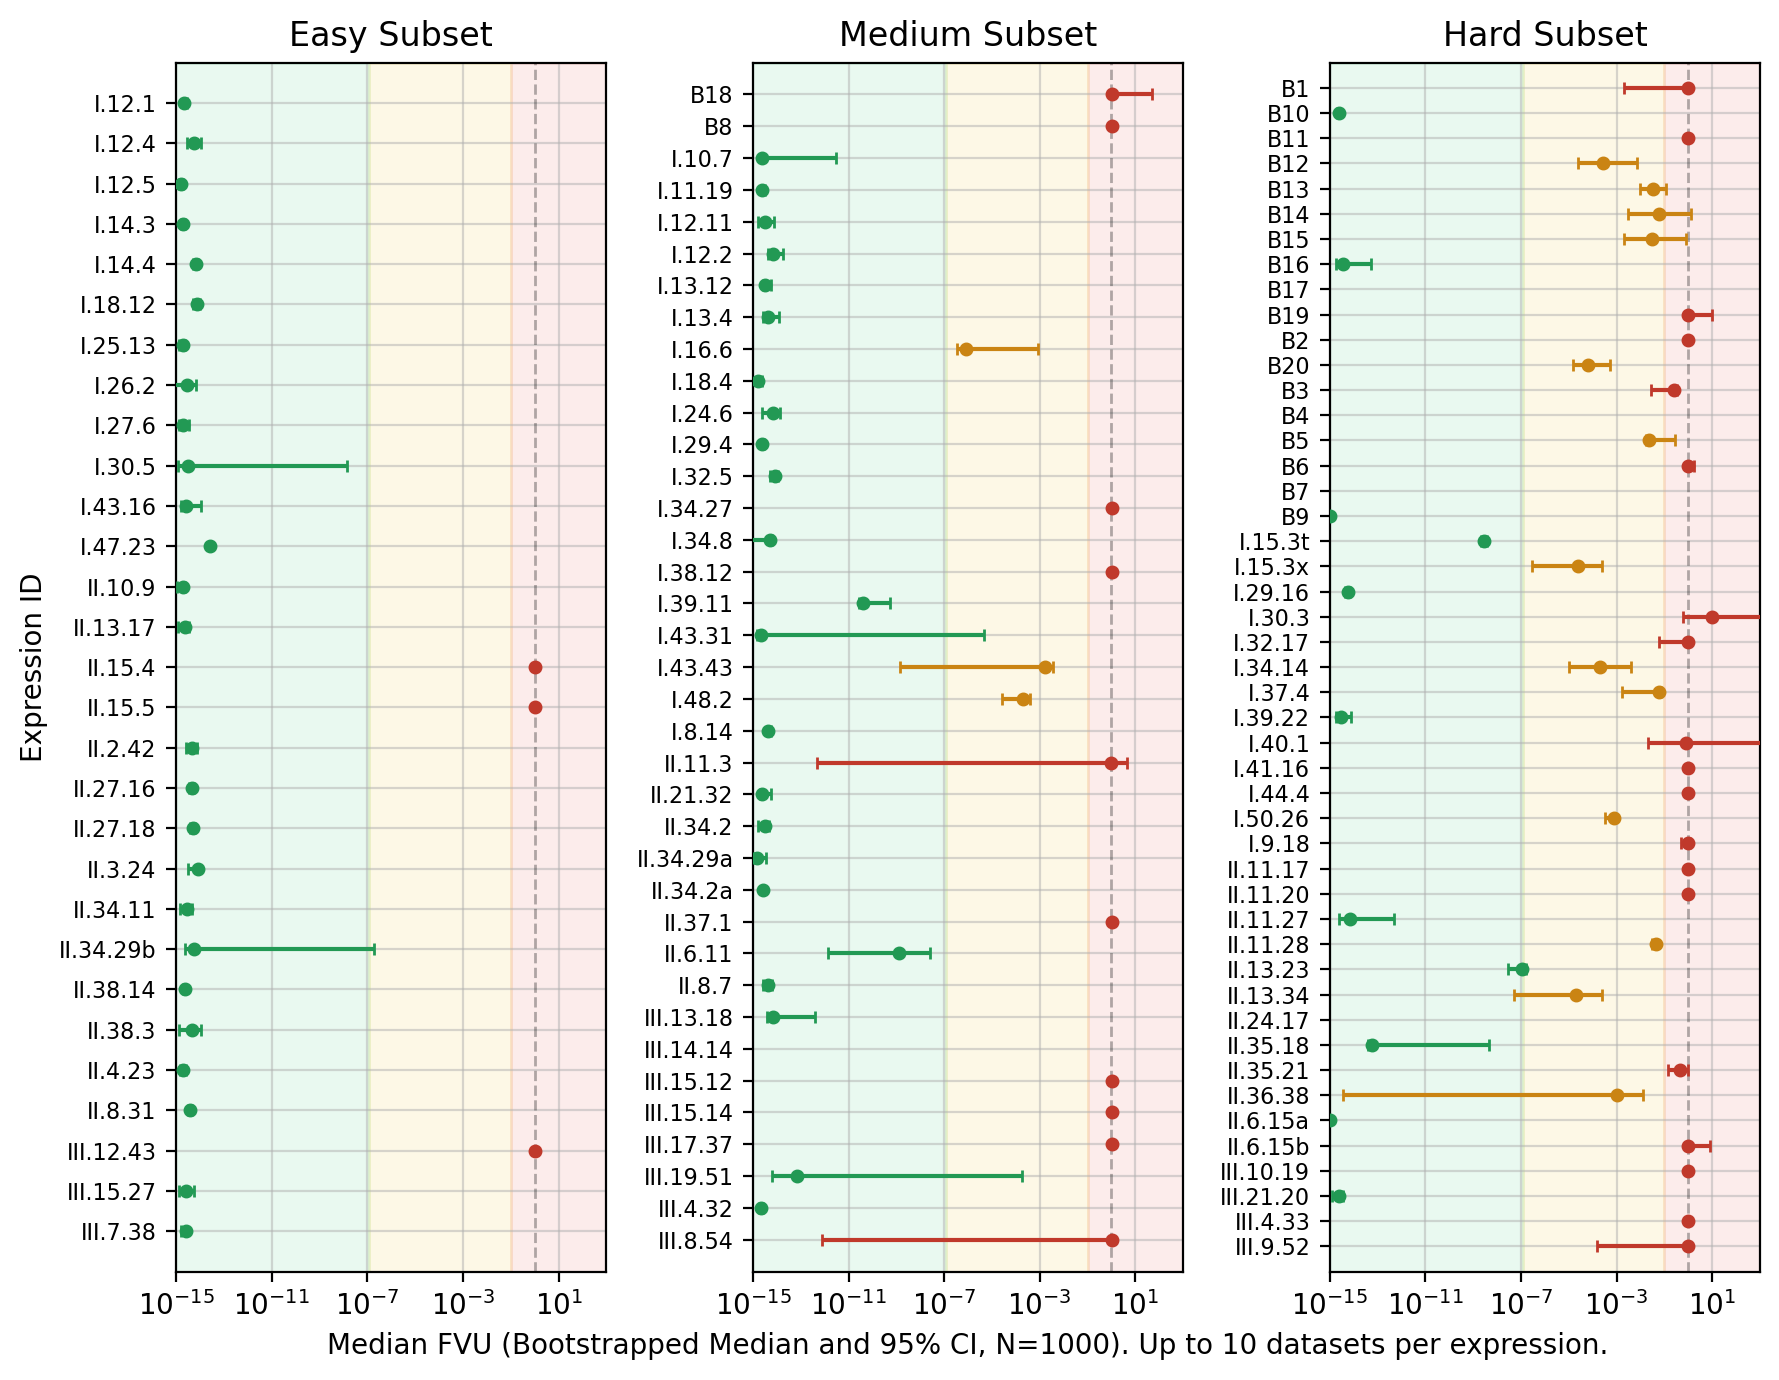

In [29]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

difficulties = [
    ("Easy", easy_ids),
    ("Medium", medium_ids),
    ("Hard", hard_ids),
]

spans = {
    "Good": (0, np.finfo(np.float32).eps, "#229954"),
    "Mediocre": (np.finfo(np.float32).eps, 1e-1, "#ca8413"),
    "Poor": (1e-1, 1e6, '#c0392b'),
}

fig, axes = plt.subplots(1, len(difficulties), figsize=(9, 7), dpi=200, sharex=True)
axes = np.atleast_1d(axes)

cmap = LinearSegmentedColormap.from_list("fvu_green_red", ["#2ecc71", "#e74c3c"])
log_norm = Normalize(vmin=np.log10(np.finfo(np.float32).eps), vmax=0.0)

for ax, (difficulty_name, difficulty_ids) in zip(axes, difficulties):
    ax: plt.Axes
    subset_ids = sorted(expr_id for expr_id in difficulty_ids if expr_id in grouped_results)[::-1]
    if not subset_ids:
        ax.text(0.5, 0.5, f"No data for {difficulty_name}", ha="center", va="center")
        ax.axis("off")
        continue

    fvu_vals, fvu_val_lowers, fvu_val_uppers = [], [], []
    for expr_id in subset_ids:
        fvu_ci = grouped_results[expr_id]['fvu_val']['median']
        fvu_vals.append(fvu_ci[0])
        fvu_val_lowers.append(fvu_ci[0] - fvu_ci[1])
        fvu_val_uppers.append(fvu_ci[2] - fvu_ci[0])

    y_pos = np.arange(len(subset_ids))
    for idx, (expr_id, fvu, lower, upper) in enumerate(zip(subset_ids, fvu_vals, fvu_val_lowers, fvu_val_uppers)):
        clipped_fvu = np.clip(fvu, 1e-15, None)
        log_fvu = np.log10(clipped_fvu)
        
        span = 'Poor'
        for span_name, (span_lower, span_upper, span_color) in spans.items():
            if span_lower <= fvu <= span_upper:
                span = span_name
                break

        ax.errorbar(
            clipped_fvu,
            y_pos[idx],
            xerr=[[lower], [upper]],
            zorder=3,
            capsize=2,
            fmt='o',
            markersize=4,
            color=spans[span][2],
        )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(subset_ids, fontsize=8)
    ax.invert_yaxis()
    ax.set_xscale('log')
    ax.set_title(f'{difficulty_name} Subset')
    ax.grid(alpha=0.5, zorder=0)
    ax.set_ylim(-1, len(subset_ids))

    # Good
    ax.axvspan(0, np.finfo(np.float32).eps, color='#2ecc71', alpha=0.1, zorder=1)
    # Mediocre
    ax.axvspan(np.finfo(np.float32).eps, 1e-1, color='#f1c40f', alpha=0.1, zorder=1)
    # Poor
    ax.axvspan(1e-1, 1e6, color='#e74c3c', alpha=0.1, zorder=1)

    ax.axvline(1, color='k', linestyle='--', alpha=0.3, zorder=2, linewidth=1)

axes[0].set_xlim(1e-15, 1e3)
axes[1].set_xlabel('Median FVU (Bootstrapped Median and 95% CI, N=1000). Up to 10 datasets per expression.')
axes[0].set_ylabel('Expression ID')

fig.tight_layout()

plt.savefig(get_path('results', 'test_time_compute', create=True, filename=f'fastsrb_expression_fvu_by_difficulty.svg'), dpi=200)

---

In [30]:
# r = results['v23.0-120M']['results']['fastsrb'][16384]

# previous_eq_id = None
# for gt_skeleton, pred_skeleton, eq_id, log10_fvu_val in zip(r['skeleton_simplified'], r['predicted_skeleton_prefix'], r['benchmark_eq_id'], r['log10_fvu_val']):
#     if eq_id != previous_eq_id:
#         print(f"\n--- Equation ID: {eq_id} ---")
#         previous_eq_id = eq_id
#     print("Ground Truth:  y =", engine.prefix_to_infix(gt_skeleton))
#     try:
#         print("Prediction:    y =", engine.prefix_to_infix(pred_skeleton))
#     except:
#         print("Prediction:    y =", pred_skeleton)
#     print("Log10 FVU:     ", f"{log10_fvu_val:.2f}")
#     print()

Text(0, 0.5, 'log10 FVU')

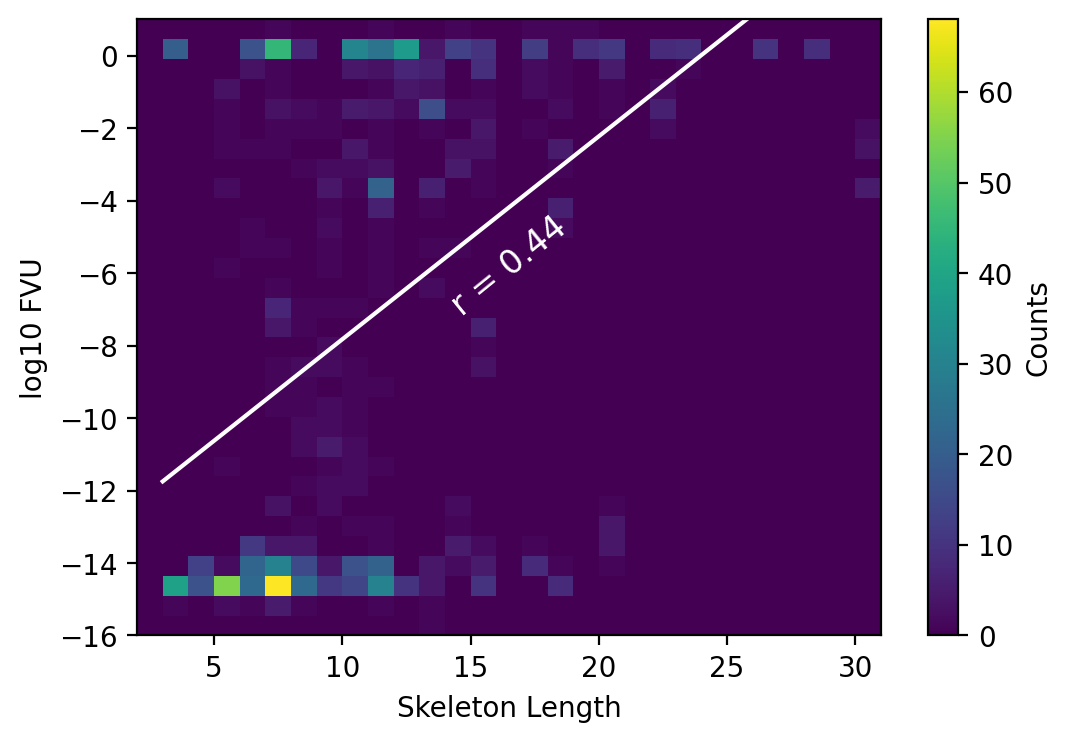

In [31]:
MODEL = 'v23.0-120M'
SCALING_PARAMETER_VALUE = 16384
TEST_SET = 'fastsrb'

skeleton_lengths = results[MODEL]['results'][TEST_SET][SCALING_PARAMETER_VALUE]['skeleton_length']
fvu_vals = results[MODEL]['results'][TEST_SET][SCALING_PARAMETER_VALUE]['fvu_val']

valid_mask = np.isfinite(skeleton_lengths) & np.isfinite(fvu_vals)
valid_mask &= skeleton_lengths > 0
valid_mask &= fvu_vals > 0

x = skeleton_lengths[valid_mask]
y = np.log10(fvu_vals[valid_mask])

# Correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
hist = ax.hist2d(x, y, bins=(np.arange(2, 32), np.linspace(-16, 1, 16 * 2)), cmap='viridis')

ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='white')
# Annotate correlation coefficient parallel to the line
ax.annotate(f'r = {correlation:.2f}', xy=(0.5, 0.6), xycoords='axes fraction', color='white', fontsize=12, ha='center', va='center', rotation=39)

fig.colorbar(hist[3], ax=ax, label='Counts')

ax.set_xlabel('Skeleton Length')
ax.set_ylabel('log10 FVU')

In [32]:
# Correlation coefficients for all scaling parameter values
scaling_values = results[MODEL]['scaling_values']
correlations = []
for n in scaling_values:
    skeleton_lengths = results[MODEL]['results']['fastsrb'][n]['skeleton_length']
    fvu_vals = results[MODEL]['results']['fastsrb'][n]['fvu_val']

    valid_mask = np.isfinite(skeleton_lengths) & np.isfinite(fvu_vals)
    valid_mask &= skeleton_lengths > 0
    valid_mask &= fvu_vals > 0

    x = skeleton_lengths[valid_mask]
    y = np.log10(fvu_vals[valid_mask])

    # correlation = np.corrcoef(x, y)[0, 1]
    correlation_median, correlation_lower, correlation_upper = bootstrapped_metric_ci(
        np.vstack([x, y]).T,
        lambda data: np.corrcoef(data[:, 0], data[:, 1])[0, 1],
        n=1000,
        interval=0.95,
    )
    correlations.append((n, correlation_median, correlation_lower, correlation_upper))

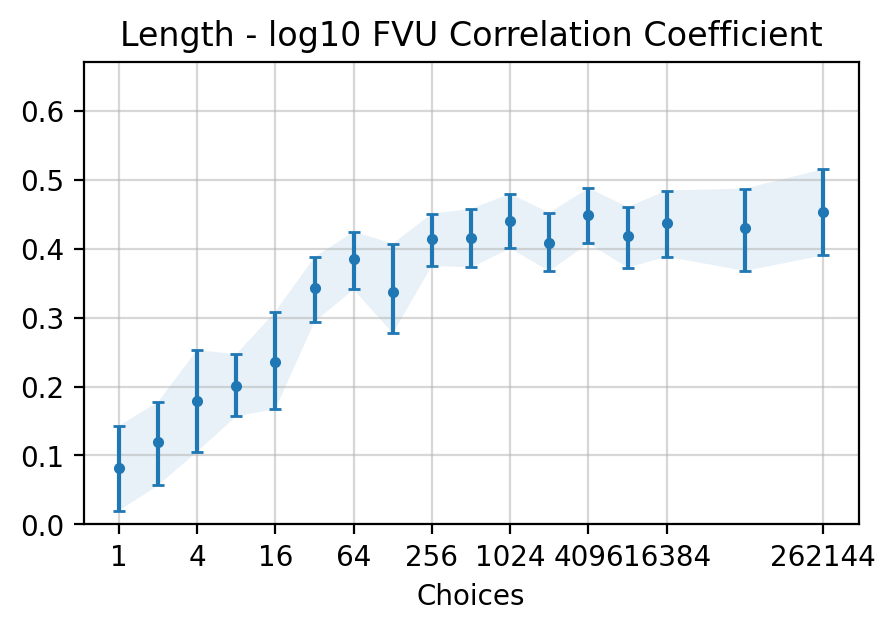

In [33]:
x = np.array([c[0] for c in correlations])
y = np.array([c[1] for c in correlations])
y_lower = y - np.array([c[2] for c in correlations])
y_upper = np.array([c[3] for c in correlations]) - y

fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
ax.errorbar(np.log2(x), y, yerr=[y_lower, y_upper], fmt='.', capsize=2)
ax.fill_between(np.log2(x), y - y_lower, y + y_upper, alpha=0.1)
ax.set_xlabel('Choices')
ax.set_title('Length - log10 FVU Correlation Coefficient')
ax.set_xticks(np.log2(scaling_values[::2]))
ax.set_xticklabels([str(scaling_values[::2][i]) for i in range(len(scaling_values[::2]))])
ax.set_ylim(0, .67)
ax.grid(alpha=0.5)

In [34]:
expression_ids = results[list(results.keys())[0]]['results']['fastsrb'][1]['benchmark_eq_id'].tolist()

model = 'v23.0-120M'
interesting_metrics = [
    'recall_unique_variables',
    'log10_fvu_val',
]

per_eq_evolution = {}
for expr_id in tqdm(set(expression_ids)):
    per_eq_evolution[expr_id] = {}
    for scaling_parameter_value in results[model]['results']['fastsrb'].keys():
        r = results[model]['results']['fastsrb'][scaling_parameter_value]
        mask = r['benchmark_eq_id'] == expr_id
        per_eq_evolution[expr_id][scaling_parameter_value] = {}
        for metric in interesting_metrics:
            values = r[metric][mask]
            per_eq_evolution[expr_id][scaling_parameter_value][metric] = {
            'mean': bootstrapped_metric_ci(values, np.nanmean, n=100, interval=0.95),
            'median': bootstrapped_metric_ci(values, np.nanmedian, n=100, interval=0.95),
        }

  0%|          | 0/120 [00:00<?, ?it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
  1%|          | 1/120 [00:00<00:12,  9.32it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
  8%|▊         | 9/120 [00:00<00:10, 10.33it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/lib/_shape_base_impl.py:393: RuntimeWarning: Mean of empty slice
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/home/psaegert/minic

In [35]:
unique_expressions_with_recall_behavior = set()

# Find out for which expressions the recall gets worse but the FVU stays the same or improves
for expr_id, scaling_dict in per_eq_evolution.items():
    sorted_scaling_values = sorted(scaling_dict.keys())
    previous_recall = None
    previous_fvu = None
    for scaling_value in sorted_scaling_values:
        recall_ci = scaling_dict[scaling_value]['recall_unique_variables']['median']
        fvu_ci = scaling_dict[scaling_value]['log10_fvu_val']['median']
        recall = recall_ci[0]
        fvu = fvu_ci[0]

        if previous_recall is not None and previous_fvu is not None:
            if recall < previous_recall and fvu <= previous_fvu:
                unique_expressions_with_recall_behavior.add(expr_id)
                # print(f"Expression {expr_id} has worse recall ({previous_recall:.3f} -> {recall:.3f}) but same or better FVU ({previous_fvu:.3f} -> {fvu:.3f}) when increasing scaling parameter from {prev_scaling_value} to {scaling_value}.")

        previous_recall = recall
        previous_fvu = fvu
        prev_scaling_value = scaling_value

unique_expressions_with_recall_behavior

{'B10',
 'B11',
 'B12',
 'B15',
 'B16',
 'B18',
 'B19',
 'B2',
 'B3',
 'B5',
 'B6',
 'B8',
 'B9',
 'I.12.11',
 'I.15.3t',
 'I.18.4',
 'I.38.12',
 'I.39.22',
 'I.41.16',
 'I.44.4',
 'I.48.2',
 'I.9.18',
 'II.11.17',
 'II.11.20',
 'II.11.27',
 'II.11.28',
 'II.11.3',
 'II.35.18',
 'II.35.21',
 'II.36.38',
 'II.37.1',
 'II.6.15a',
 'II.6.15b',
 'III.10.19',
 'III.15.12',
 'III.15.14',
 'III.17.37',
 'III.4.33',
 'III.9.52'}

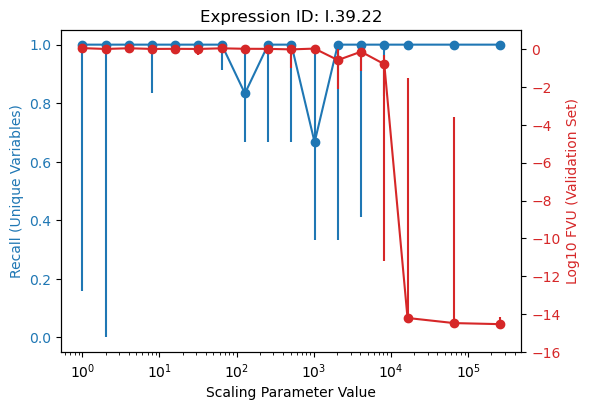

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/matplotlib/axes/_axes.py:3831: RuntimeWarning: invalid value encountered in scalar add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


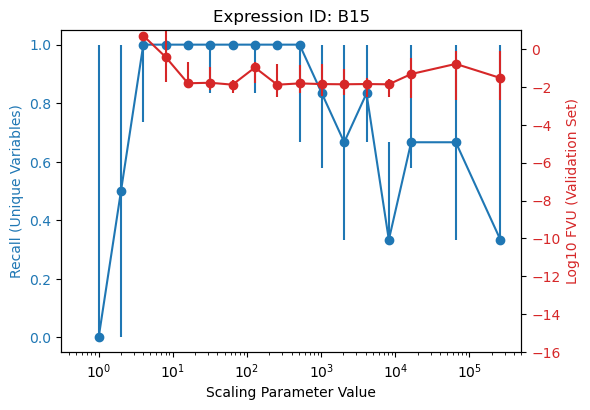

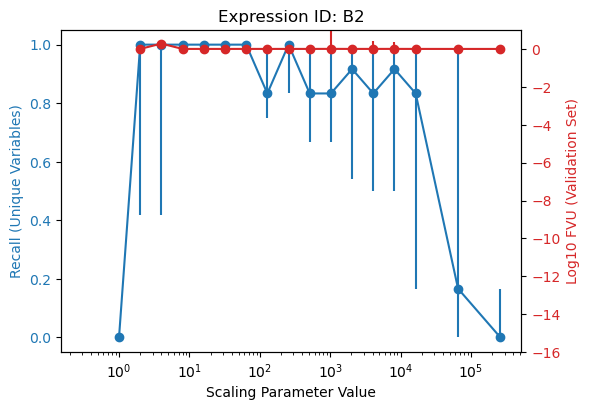

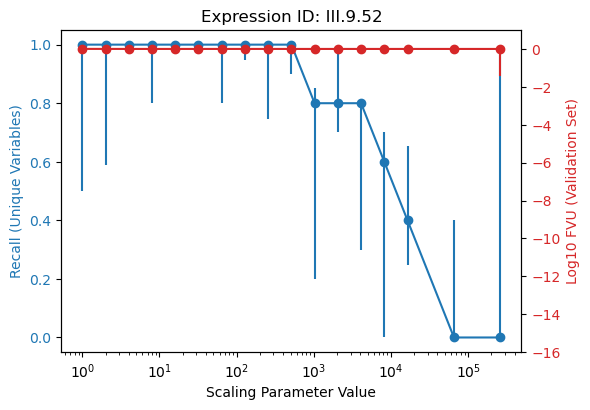

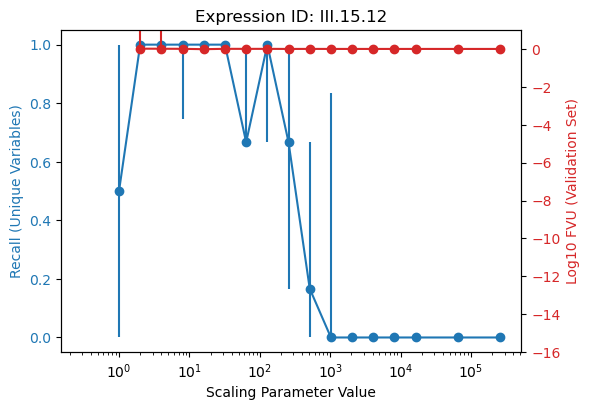

In [36]:
# Plot the evolution of recall_unique_variables and log10_fvu_val for each expression
for expr_id in list(unique_expressions_with_recall_behavior)[:5]:
    fig, ax1 = plt.subplots(figsize=(6, 4), dpi=100)

    scaling_parameters = sorted(per_eq_evolution[expr_id].keys())
    recall_medians = [per_eq_evolution[expr_id][n]['recall_unique_variables']['median'][0] for n in scaling_parameters]
    recall_lowers = [per_eq_evolution[expr_id][n]['recall_unique_variables']['median'][1] for n in scaling_parameters]
    recall_uppers = [per_eq_evolution[expr_id][n]['recall_unique_variables']['median'][2] for n in scaling_parameters]

    fvu_medians = [per_eq_evolution[expr_id][n]['log10_fvu_val']['median'][0] for n in scaling_parameters]
    fvu_lowers = [per_eq_evolution[expr_id][n]['log10_fvu_val']['median'][1] for n in scaling_parameters]
    fvu_uppers = [per_eq_evolution[expr_id][n]['log10_fvu_val']['median'][2] for n in scaling_parameters]

    ax1.errorbar(scaling_parameters, recall_medians, yerr=[np.array(recall_medians) - np.array(recall_lowers), np.array(recall_uppers) - np.array(recall_medians)], fmt='-o', color='tab:blue', label='Recall (Unique Variables)')
    ax1.set_xlabel('Scaling Parameter Value')
    ax1.set_ylabel('Recall (Unique Variables)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xscale('log')
    ax1.set_ylim(-0.05, 1.05)

    ax2 = ax1.twinx()
    ax2.errorbar(scaling_parameters, fvu_medians, yerr=[np.array(fvu_medians) - np.array(fvu_lowers), np.array(fvu_uppers) - np.array(fvu_medians)], fmt='-o', color='tab:red', label='Log10 FVU (Validation Set)')
    ax2.set_ylabel('Log10 FVU (Validation Set)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(-16, 1)

    fig.tight_layout()
    plt.title(f'Expression ID: {expr_id}')
    plt.show()

In [37]:
expresison_id = list(unique_expressions_with_recall_behavior)[2]
print(f"Analyzing expression ID: {expresison_id}")

# Print the ground truth expression
r = results['v23.0-120M']['results']['fastsrb'][1]
mask = r['benchmark_eq_id'] == expresison_id
ground_truth_expression = [skeleton for skeleton, m in zip(r['skeleton_simplified'], mask) if m][0]
print(f"Ground Truth Expression: {ground_truth_expression}")
print(engine.prefix_to_infix(ground_truth_expression))

Analyzing expression ID: B2
Ground Truth Expression: ['*', 'x1', '/', 'x2', '*', 'pow2', 'x3', '+', '<constant>', '*', 'cos', '-', 'x5', 'x6', 'pow1_2', '+', '<constant>', '*', '<constant>', '*', 'x4', '/', 'pow2', 'x3', '*', 'x1', 'pow2', 'x2']
x1 * x2 / (pow2(x3) * (<constant> + cos(x5 - x6) * pow1_2(<constant> + <constant> * x4 * pow2(x3) / (x1 * pow2(x2)))))


In [38]:
# # For this expression, print the predicted skeletons
# for scaling_parameter_value in sorted(results['v23.0-120M']['results']['fastsrb'].keys()):
#     r = results['v23.0-120M']['results']['fastsrb'][scaling_parameter_value]
#     mask = r['benchmark_eq_id'] == expresison_id
#     predicted_skeletons = [skeleton for skeleton, m in zip(r['predicted_skeleton_prefix'], mask) if m]
#     fvu_values = [fvu for fvu, m in zip(r['fvu_val'], mask) if m]

#     if not predicted_skeletons:
#         continue

#     print(f"\n--- Scaling Parameter: {scaling_parameter_value} ---")
#     for predicted_skeleton, fvu in zip(predicted_skeletons, fvu_values):
#         if predicted_skeleton is None:
#             print("Predicted Skeleton: None")
#             continue
#         print(f'{sorted(list(set(token for token in predicted_skeleton if (token is not None and token.startswith("x")))), key=lambda x: int(x[1:]))} | FVU: {fvu:.3e}')
#         print(f"Infix: {engine.prefix_to_infix(predicted_skeleton)}")


In [39]:
import pandas as pd
import shap
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### SHAP objective and feature design
We model $\log_{10}(\mathrm{FVU}_{\text{val}})$ as a function of both previously plotted diagnostics (e.g., `skeleton_length`, `predicted_total_nestedness`, `numeric_recovery_val`) and richer statistics of the data tensors. In addition to the metrics defined above, we'll engineer new features that aim to capture how the support sets influence fit quality:
- **Data tensor statistics:** column-wise spread (`x_std_mean`, `x_range_mean`), absolute scale (`x_abs_mean`), condition number of the design matrix, median support radius, label variability (`y_std`, `y_span`, `y_abs_mean`), an empirical noise ratio (`y_noise_ratio`), and sampling density (`support_density`).
- **Ground-truth signal descriptors:** span and standard deviation of ground-truth constants (`gt_constant_span`, `gt_constant_std`) and variable-to-length ratios highlighting symbolic complexity pressure.
- **Prediction-structure couplings:** ratios of predicted constants/variables to sequence length, `predicted_constant_share`, and `skeleton_variable_ratio`, plus the existing edit-distance, numeric recovery, and nestedness statistics.

We'll assemble these into a modeling DataFrame, fit an XGBoost regressor, and use SHAP to explain which properties drive lower vs. higher $\log_{10}(\mathrm{FVU})$.

In [40]:
from typing import Any, Iterable, Optional

# Select a rich run (fallbacks keep the cell robust if configs change)
TARGET_MODEL = 'v23.0-120M'
TARGET_MODEL = TARGET_MODEL if TARGET_MODEL in results else next(iter(results.keys()))
model_results = results[TARGET_MODEL]['results']

TARGET_DATASET = 'fastsrb'
TARGET_DATASET = TARGET_DATASET if TARGET_DATASET in model_results else next(iter(model_results.keys()))
TARGET_SCALING = max(model_results[TARGET_DATASET].keys())

run_result = model_results[TARGET_DATASET][TARGET_SCALING]
num_examples = len(run_result['fvu_val'])

BASE_FEATURES = [
    'skeleton_length',
    'expression_length',
    'predicted_skeleton_prefix_length',
    'predicted_total_nestedness',
    'n_support',
    'n_variables',
    'n_constants',
    'predicted_n_constants',
    'n_constants_delta',
    'symbolic_recovery',
    'precision_unique_variables',
    'recall_unique_variables',
    'edit_distance',
    'zss_edit_distance',
    'f1_score',
    'fit_time',
]

def _safe_fetch(container: dict, key: str, idx: int) -> Any:
    value = container.get(key)
    if value is None:
        return None
    if isinstance(value, (np.ndarray, list, tuple)):
        if len(value) > idx:
            return value[idx]
        return None
    return value

def _to_float_array(value: Any) -> Optional[np.ndarray]:
    if value is None:
        return None
    try:
        arr = np.asarray(value, dtype=np.float64)
    except (ValueError, TypeError):
        return None
    if arr.size == 0:
        return None
    return arr

def _nanmean_abs(arr: Any) -> float:
    data = _to_float_array(arr)
    if data is None:
        return np.nan
    return float(np.nanmean(np.abs(data)))

def _nanstd(arr: Any) -> float:
    data = _to_float_array(arr)
    if data is None:
        return np.nan
    return float(np.nanstd(data))

def _nanspan(arr: Any) -> float:
    data = _to_float_array(arr)
    if data is None:
        return np.nan
    return float(np.nanmax(data) - np.nanmin(data))

def _column_stat(arr: Any, reducer) -> float:
    data = _to_float_array(arr)
    if data is None:
        return np.nan
    if data.ndim == 1:
        data = data[:, None]
    if data.ndim != 2:
        return np.nan
    values = reducer(data)
    values = np.asarray(values, dtype=np.float64)
    if values.size == 0:
        return np.nan
    return float(np.nanmean(values))

def _condition_number(arr: Any) -> float:
    data = _to_float_array(arr)
    if data is None or data.ndim != 2 or min(data.shape) < 2:
        return np.nan
    mask = np.all(np.isfinite(data), axis=1)
    data = data[mask]
    if data.shape[0] < 2:
        return np.nan
    try:
        cond = float(np.linalg.cond(data))
    except np.linalg.LinAlgError:
        return np.nan
    return cond

def _median_radius(arr: Any) -> float:
    data = _to_float_array(arr)
    if data is None or data.ndim != 2:
        return np.nan
    norms = np.linalg.norm(data, axis=1)
    if norms.size == 0:
        return np.nan
    return float(np.nanmedian(norms))

def _safe_ratio(a: Any, b: Any) -> float:
    if a is None or b is None:
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b) or b == 0:
        return np.nan
    return float(a / b)

def _len_or_nan(value: Any) -> float:
    if value is None:
        return np.nan
    if isinstance(value, (list, tuple, set, np.ndarray)):
        return float(len(value)) if len(value) else np.nan
    try:
        val = float(value)
    except (ValueError, TypeError):
        return np.nan
    return val

records = []
for idx in range(num_examples):
    fvu_fit = _safe_fetch(run_result, 'fvu_fit', idx)
    fvu_val = _safe_fetch(run_result, 'fvu_val', idx)
    if fvu_val is None or not np.isfinite(fvu_val) or fvu_val <= 0:
        continue

    row = {
        'log10_fvu_overfit':  np.log10(np.clip(fvu_val, 1e-16, None)) - float(np.log10(np.clip(fvu_fit, 1e-16, None))),
        }

    for feature_name in BASE_FEATURES:
        value = _safe_fetch(run_result, feature_name, idx)
        if value is None:
            row[feature_name] = np.nan
        elif np.isscalar(value):
            row[feature_name] = float(value)
        else:
            row[feature_name] = np.nan

    x_tensor = _safe_fetch(run_result, 'x', idx)
    y_tensor = _safe_fetch(run_result, 'y', idx)
    y_noisy_tensor = _safe_fetch(run_result, 'y_noisy', idx)
    gt_constants = _safe_fetch(run_result, 'gt_constants', idx)
    pred_constants = _safe_fetch(run_result, 'predicted_constants', idx)
    unique_vars = _safe_fetch(run_result, 'unique_variables', idx)

    row['x_abs_mean'] = _nanmean_abs(x_tensor)
    row['x_std_mean'] = _column_stat(x_tensor, lambda data: np.nanstd(data, axis=0))
    row['x_range_mean'] = _column_stat(x_tensor, lambda data: np.nanmax(data, axis=0) - np.nanmin(data, axis=0))
    row['support_condition_number'] = _condition_number(x_tensor)
    row['support_median_radius'] = _median_radius(x_tensor)

    n_support_value = _safe_fetch(run_result, 'n_support', idx)
    n_variables_value = _safe_fetch(run_result, 'n_variables', idx)
    denom = n_variables_value if (n_variables_value is not None and np.isfinite(n_variables_value) and n_variables_value > 0) else np.nan
    row['support_density'] = _safe_ratio(n_support_value, denom)

    row['y_abs_mean'] = _nanmean_abs(y_tensor)
    row['y_std'] = _nanstd(y_tensor)
    row['y_span'] = _nanspan(y_tensor)

    row['y_noise_ratio'] = np.nan
    if y_noisy_tensor is not None and y_tensor is not None:
        noisy = _to_float_array(y_noisy_tensor)
        clean = _to_float_array(y_tensor)
        if noisy is not None and clean is not None:
            length = min(noisy.size, clean.size)
            if length > 1:
                diff = noisy.flatten()[:length] - clean.flatten()[:length]
                noise_std = np.nanstd(diff)
                denom_std = np.nanstd(clean)
                row['y_noise_ratio'] = float(noise_std / (denom_std + 1e-12))

    row['gt_constant_span'] = _nanspan(gt_constants)
    row['gt_constant_std'] = _nanstd(gt_constants)
    row['pred_constant_span'] = _nanspan(pred_constants)
    row['pred_constant_std'] = _nanstd(pred_constants)

    unique_var_count = _len_or_nan(unique_vars)
    row['unique_variable_count'] = unique_var_count
    skeleton_length = row.get('skeleton_length')
    expression_length = row.get('expression_length')
    predicted_length = row.get('predicted_skeleton_prefix_length')

    row['skeleton_variable_ratio'] = _safe_ratio(unique_var_count, skeleton_length)
    row['gt_constant_share'] = _safe_ratio(row.get('n_constants'), expression_length)
    row['predicted_constant_share'] = _safe_ratio(row.get('predicted_n_constants'), predicted_length)

    records.append(row)

shap_df = pd.DataFrame(records)
shap_df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)

feature_columns = [col for col in shap_df.columns if col not in {'log10_fvu_overfit'}]
feature_columns = [col for col in feature_columns if shap_df[col].notna().sum() > 0]

SHAP_FEATURE_COLUMNS = feature_columns
print(f"Prepared {len(shap_df)} samples with {len(SHAP_FEATURE_COLUMNS)} candidate features.")
shap_df[['log10_fvu_overfit'] + SHAP_FEATURE_COLUMNS].head()

Prepared 565 samples with 30 candidate features.


,log10_fvu_overfit,skeleton_length,predicted_skeleton_prefix_length,predicted_total_nestedness,n_support,n_variables,n_constants,predicted_n_constants,n_constants_delta,symbolic_recovery,...,support_density,y_abs_mean,y_std,y_span,y_noise_ratio,pred_constant_span,pred_constant_std,unique_variable_count,skeleton_variable_ratio,predicted_constant_share
0,1.145356,7.0,15.0,0.0,512.0,4.0,0.0,2.0,2.0,0.0,...,128.0,0.002130,0.014443,0.364792,0.0,0.999999,0.5,4.0,0.571429,0.133333
1,0.585877,7.0,10.0,0.0,512.0,4.0,0.0,1.0,1.0,0.0,...,128.0,0.002008,0.010059,0.249047,0.0,0.000000,0.0,4.0,0.571429,0.100000
2,0.966585,7.0,12.0,0.0,512.0,4.0,0.0,1.0,1.0,0.0,...,128.0,0.002263,0.010038,0.242650,0.0,0.000000,0.0,4.0,0.571429,0.083333
3,0.969966,7.0,9.0,0.0,512.0,4.0,0.0,1.0,1.0,0.0,...,128.0,0.002139,0.007716,0.185926,0.0,0.000000,0.0,4.0,0.571429,0.111111
4,0.321215,7.0,9.0,0.0,512.0,4.0,0.0,1.0,1.0,0.0,...,128.0,0.002129,0.010458,0.238960,0.0,0.000000,0.0,4.0,0.571429,0.111111


In [41]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_SAMPLES = 8000
CLIP_BOUNDS = (-1e12, 1e12)

if len(shap_df) == 0:
    raise ValueError('No valid samples were found for SHAP analysis.')

modeling_df = shap_df[['log10_fvu_overfit'] + SHAP_FEATURE_COLUMNS].dropna(subset=['log10_fvu_overfit']).copy()

modeling_df = modeling_df.apply(pd.to_numeric, errors='coerce')
modeling_df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)

if len(modeling_df) > MAX_SAMPLES:
    modeling_df = modeling_df.sample(MAX_SAMPLES, random_state=RANDOM_STATE)

feature_slice = modeling_df[SHAP_FEATURE_COLUMNS].clip(CLIP_BOUNDS[0], CLIP_BOUNDS[1])
feature_slice = feature_slice.fillna(feature_slice.median())

target = modeling_df['log10_fvu_overfit']

X_train, X_valid, y_train, y_valid = train_test_split(
    feature_slice,
    target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

xgb_model = xgboost.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    min_child_weight=1.0,
    n_jobs=8,
    tree_method='hist',
    random_state=RANDOM_STATE,
)

xgb_model.fit(X_train, y_train)

train_pred = xgb_model.predict(X_train)
valid_pred = xgb_model.predict(X_valid)

train_rmse = float(np.sqrt(mean_squared_error(y_train, train_pred)))
valid_rmse = float(np.sqrt(mean_squared_error(y_valid, valid_pred)))
valid_r2 = float(r2_score(y_valid, valid_pred))

print(f'Train RMSE: {train_rmse:.3f}')
print(f'Valid RMSE: {valid_rmse:.3f}')
print(f'Valid R^2: {valid_r2:.3f}')

# Persist for SHAP downstream
X_VALID_FOR_SHAP = X_valid.reset_index(drop=True)
Y_VALID_FOR_SHAP = y_valid.reset_index(drop=True)

Train RMSE: 0.030
Valid RMSE: 1.242
Valid R^2: 0.380


Computing SHAP on 113 validation samples with 30 features.


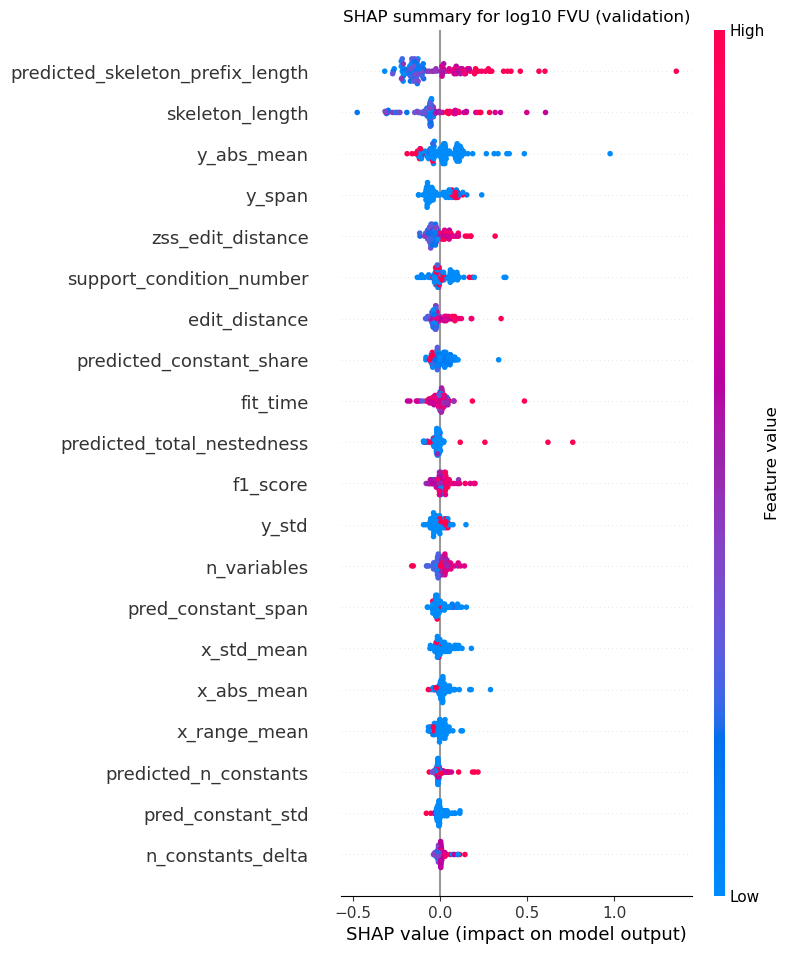

,feature,mean_abs_shap
0,predicted_skeleton_prefix_length,0.171297
1,skeleton_length,0.111533
2,y_abs_mean,0.092931
3,y_span,0.068030
4,zss_edit_distance,0.051235
5,support_condition_number,0.048722
6,edit_distance,0.043333
7,predicted_constant_share,0.036963
8,fit_time,0.035728
9,predicted_total_nestedness,0.035220


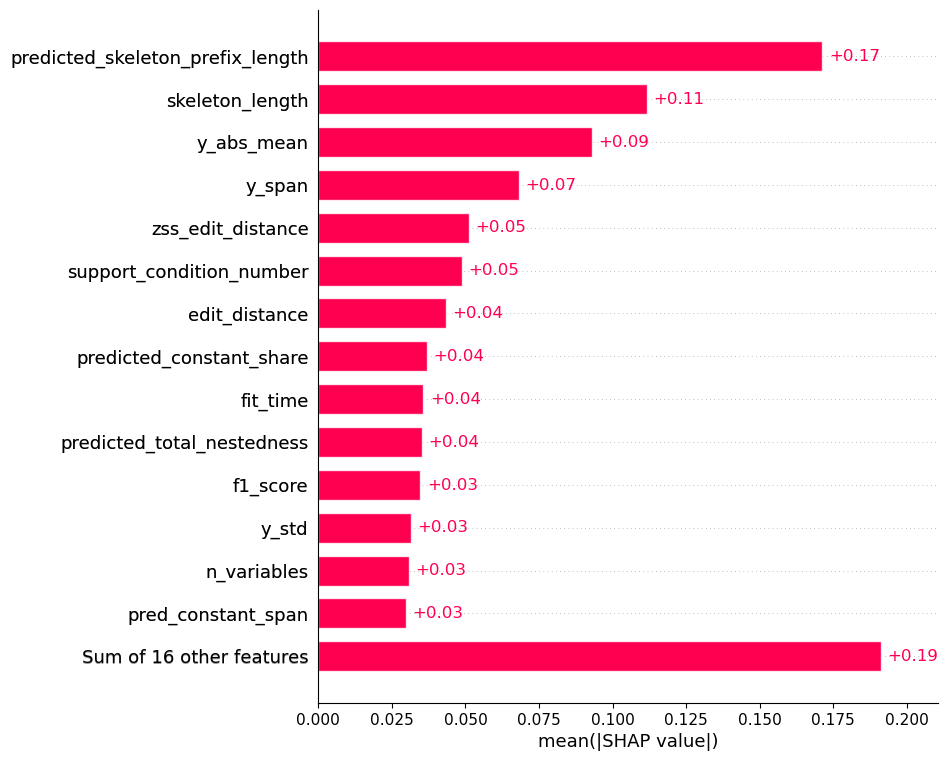

In [42]:
if 'xgb_model' not in globals():
    raise ValueError('Train the XGBoost model before running SHAP.')

explainer = shap.TreeExplainer(xgb_model)

shap_eval_df = X_VALID_FOR_SHAP.copy()
if len(shap_eval_df) > 2000:
    shap_eval_df = shap_eval_df.sample(2000, random_state=RANDOM_STATE)

shap_values = explainer(shap_eval_df)

print(f'Computing SHAP on {len(shap_eval_df)} validation samples with {len(SHAP_FEATURE_COLUMNS)} features.')

shap.summary_plot(shap_values.values, shap_eval_df, show=False, max_display=20)
plt.title('SHAP summary for log10 FVU (validation)')
plt.show()

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_feature_ranking = (
    pd.DataFrame({
        'feature': shap_eval_df.columns,
        'mean_abs_shap': mean_abs_shap,
    })
    .sort_values('mean_abs_shap', ascending=False)
    .reset_index(drop=True)
)
display(shap_feature_ranking.head(15))

shap.plots.bar(shap_values, max_display=15)

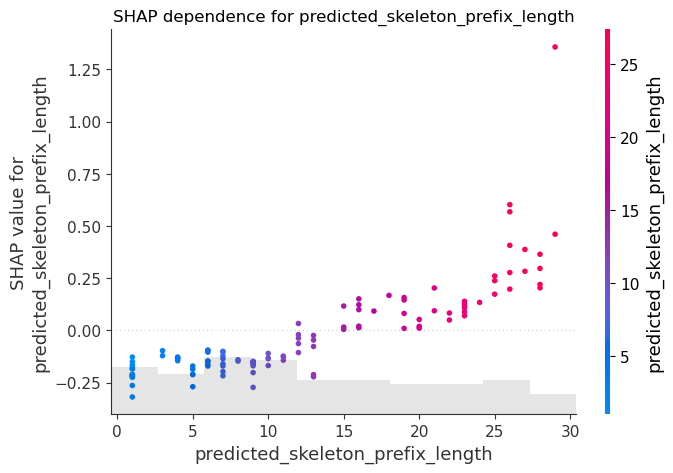

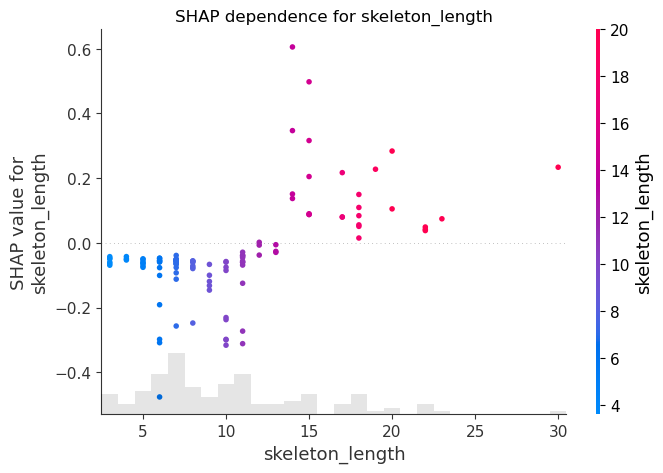

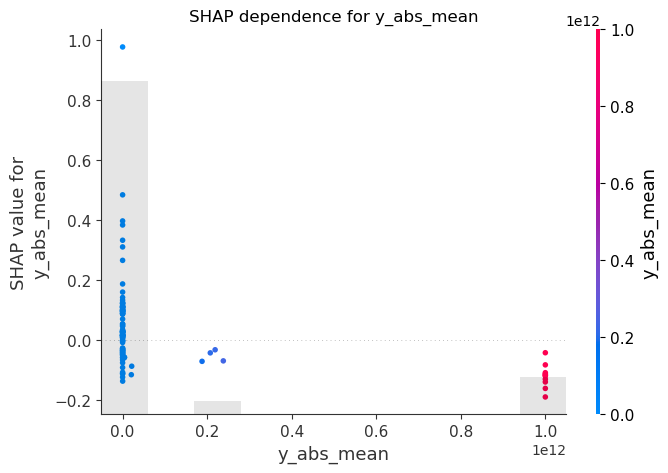

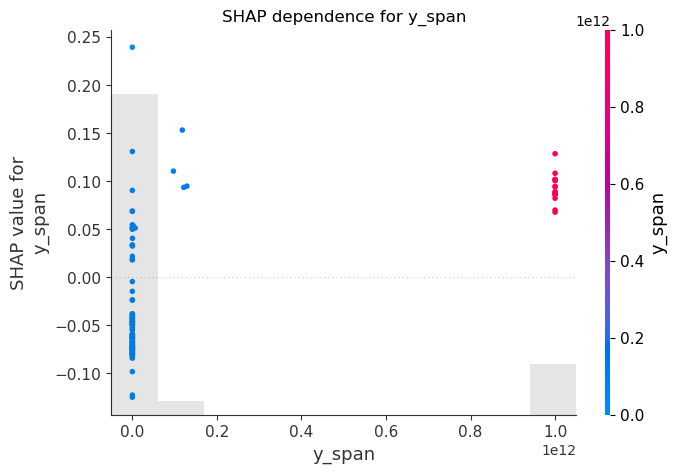

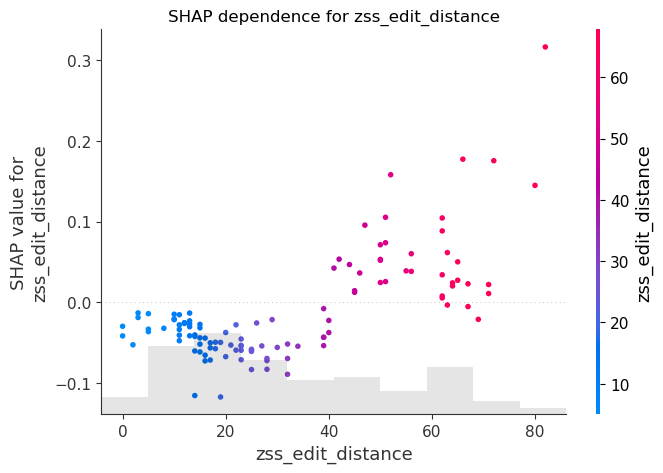

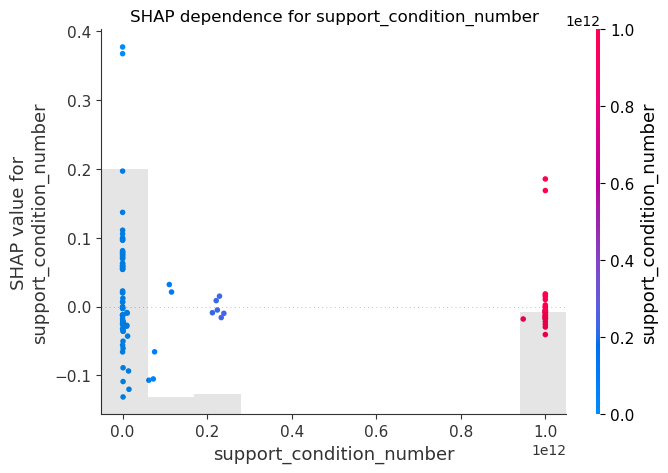

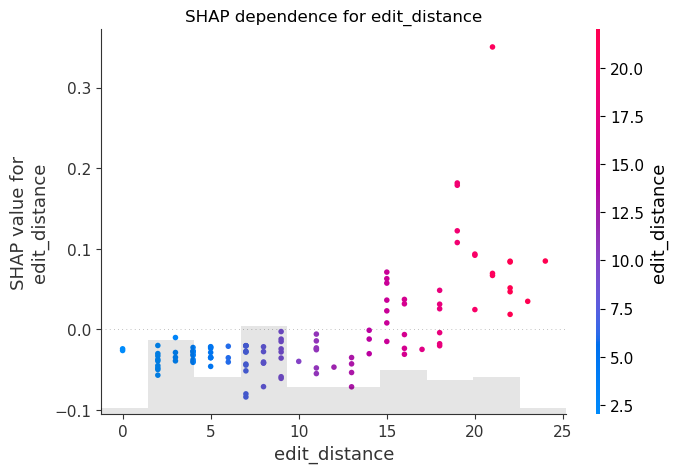

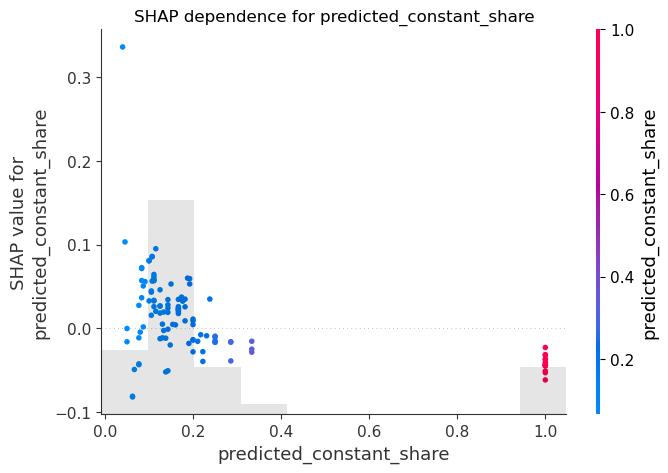

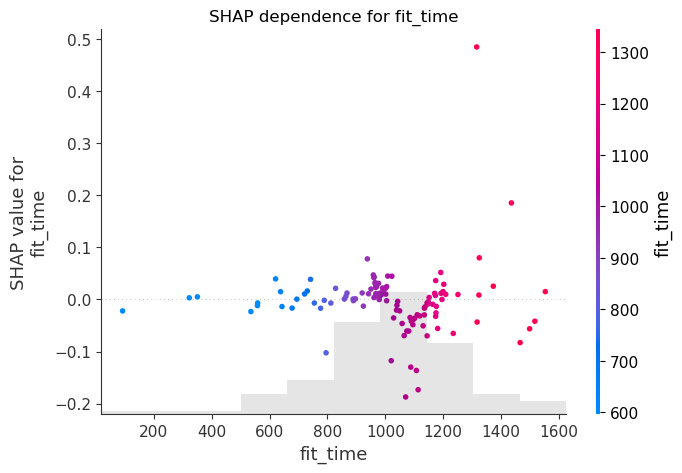

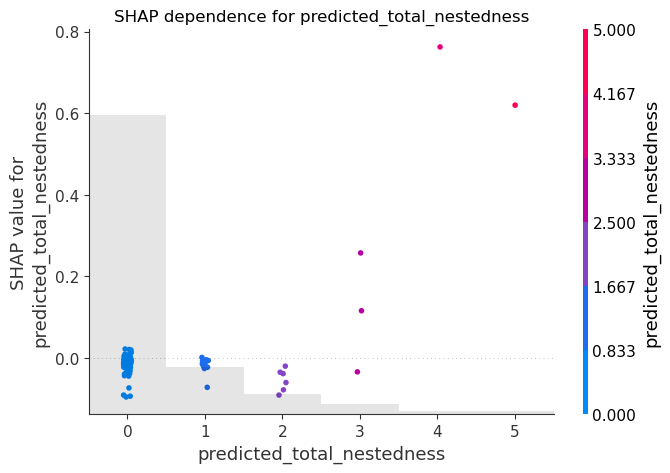

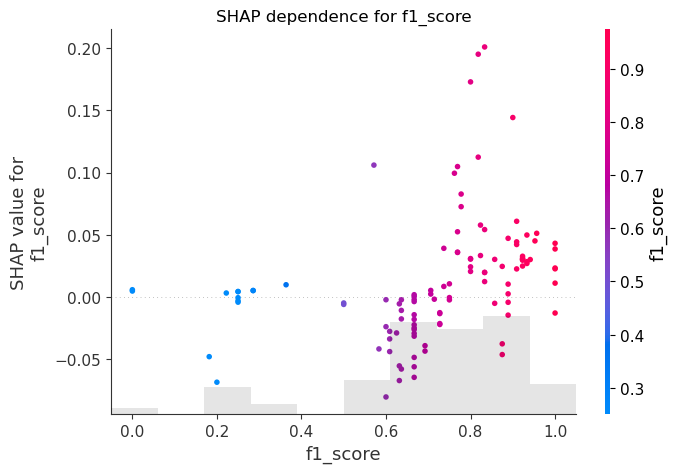

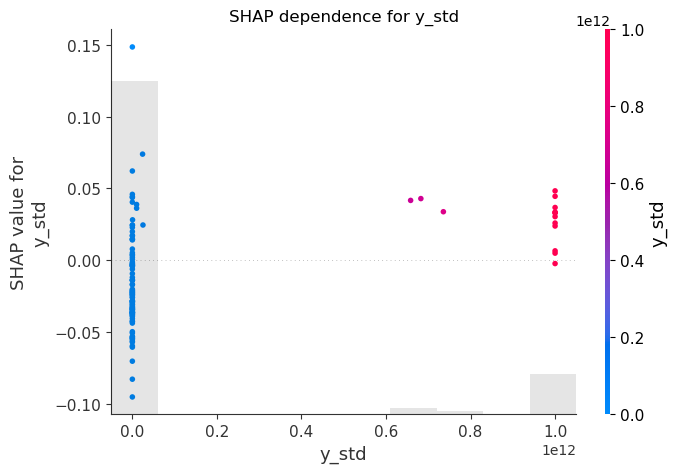

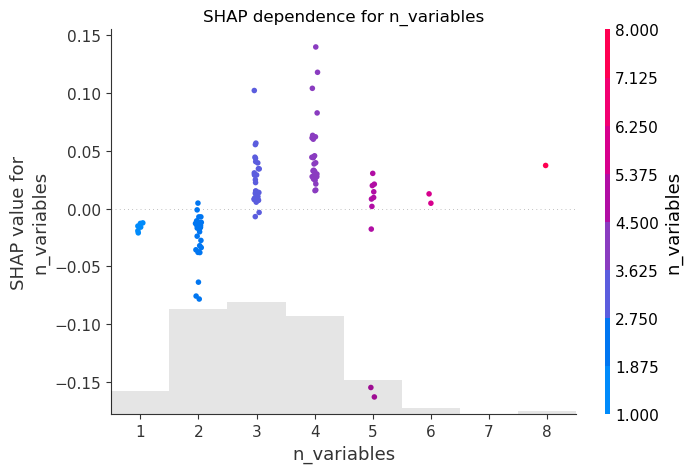

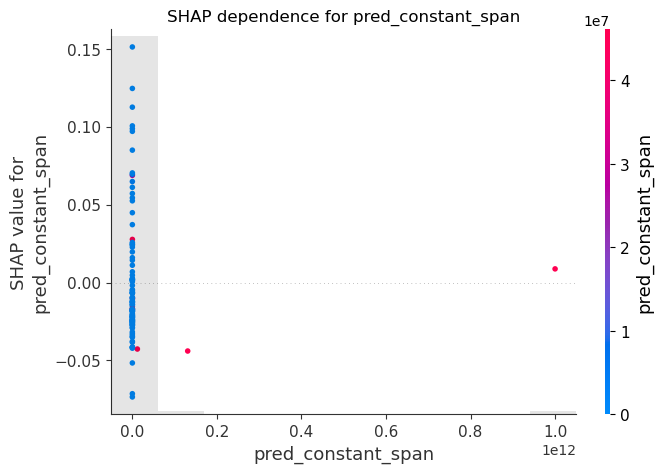

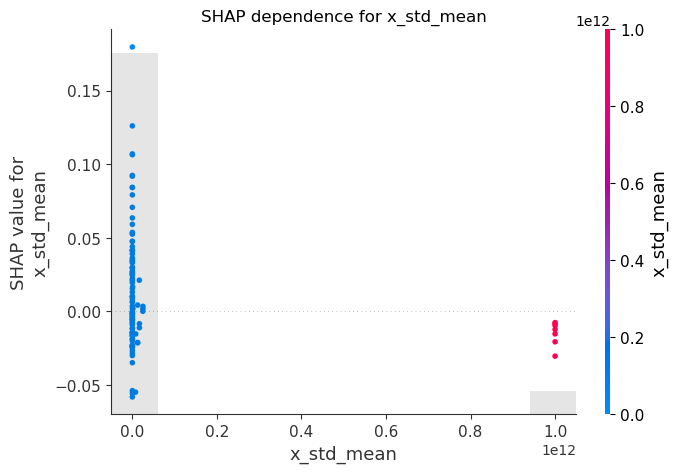

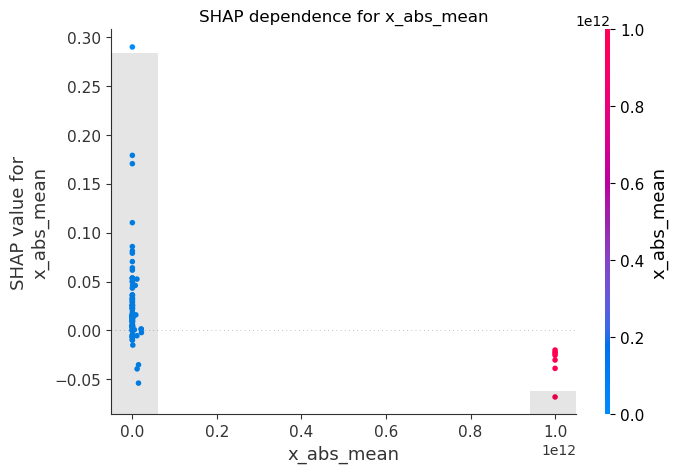

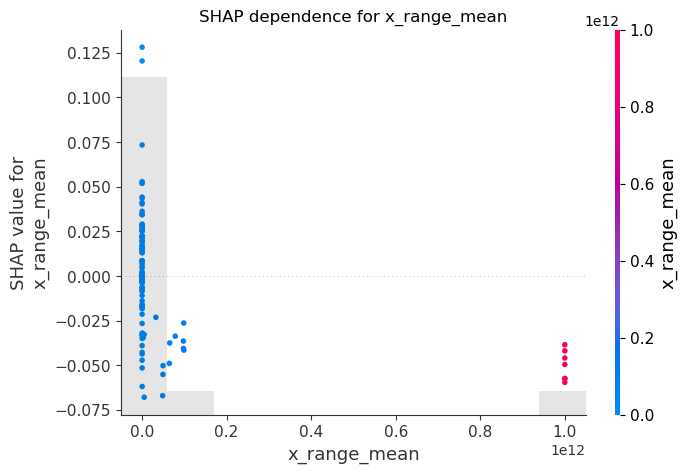

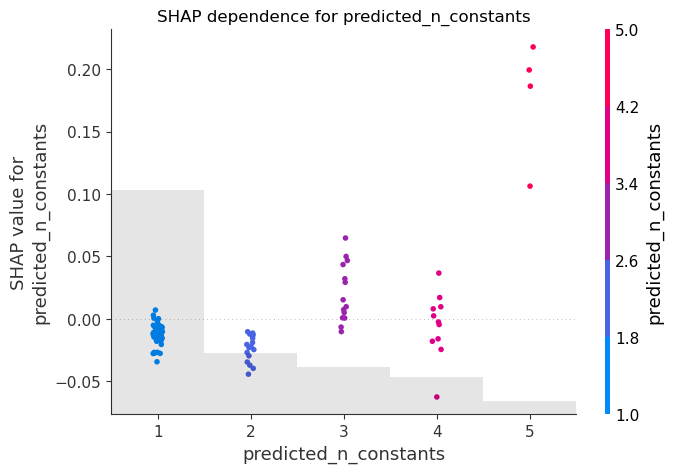

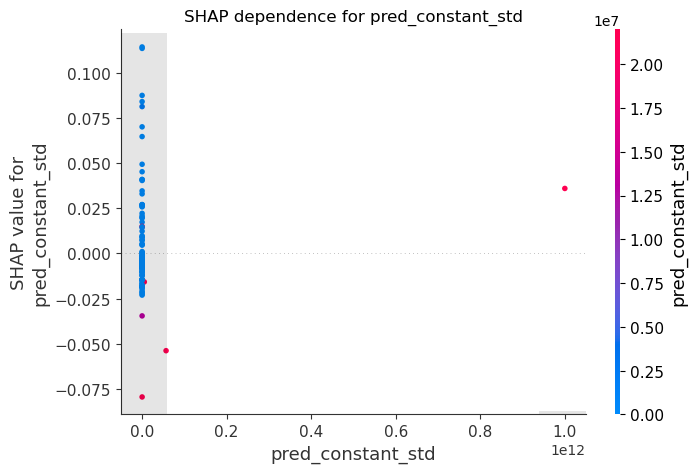

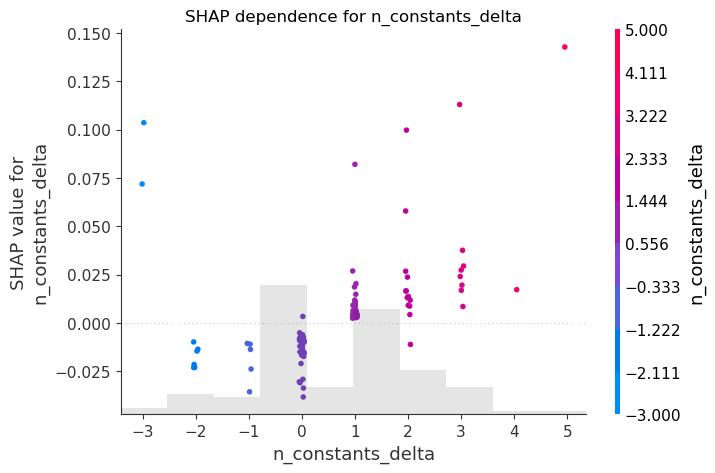

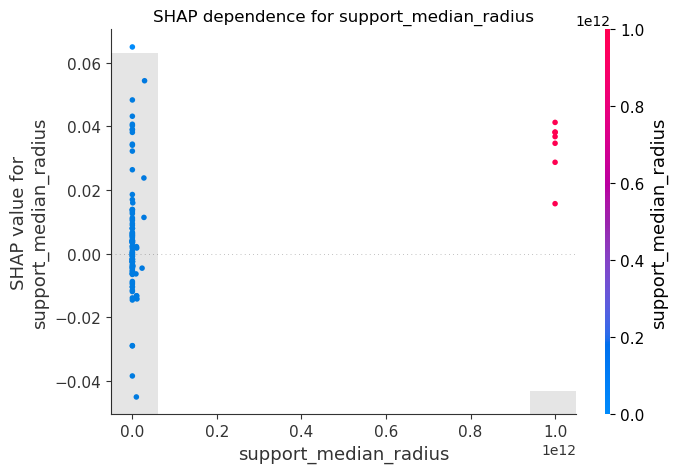

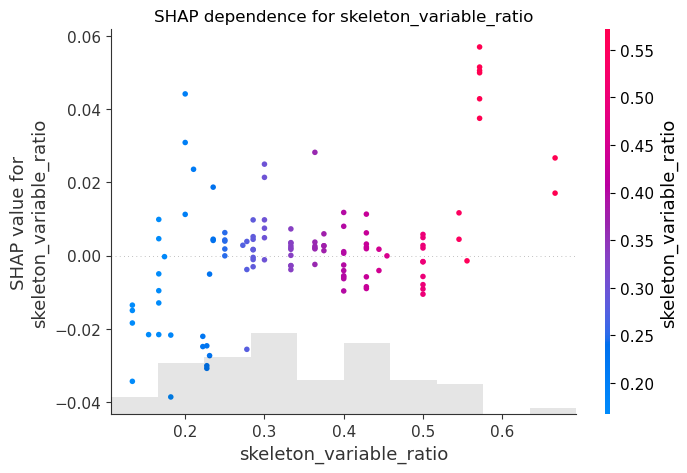

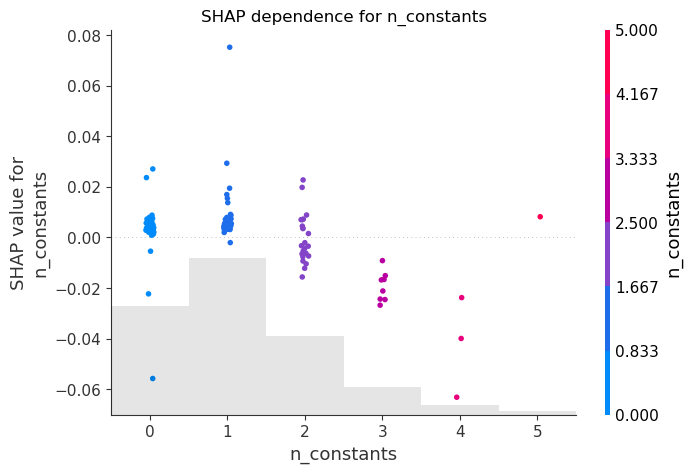

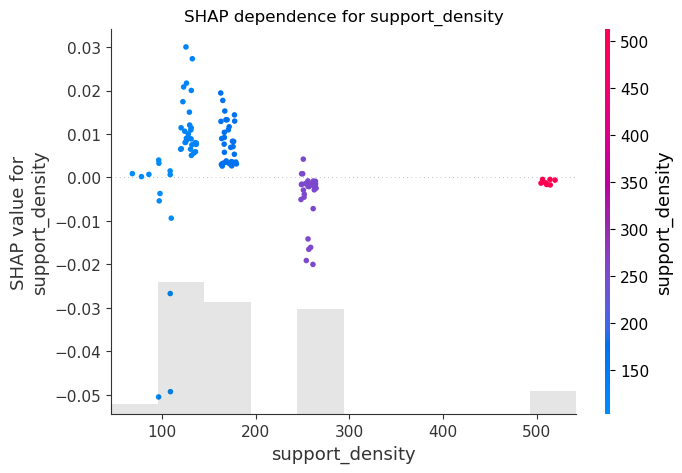

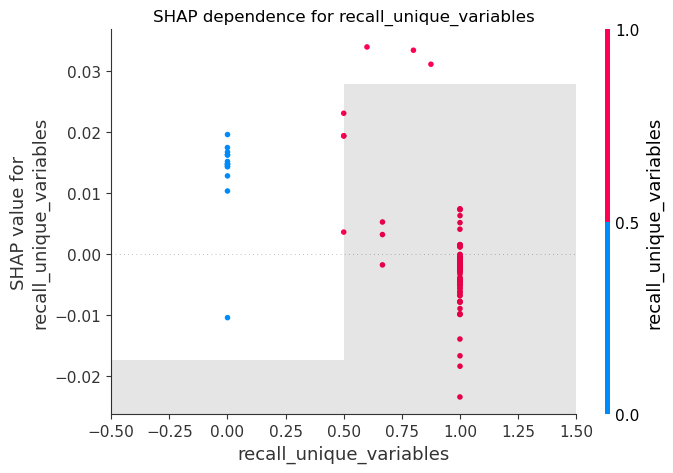

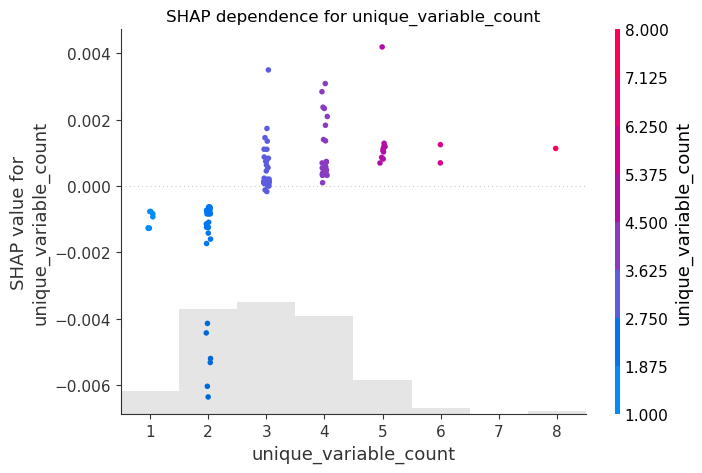

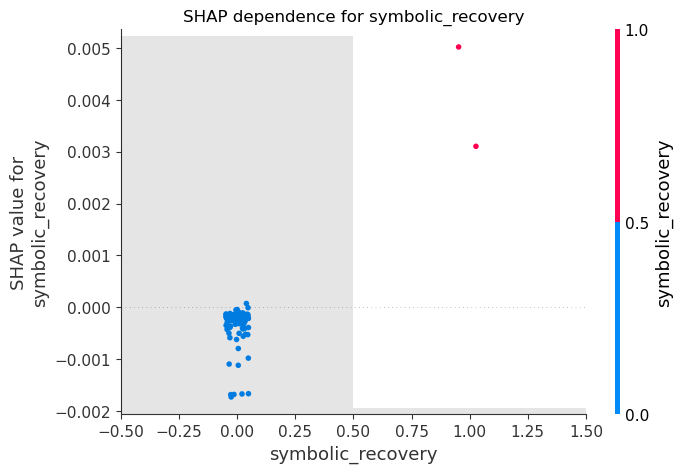

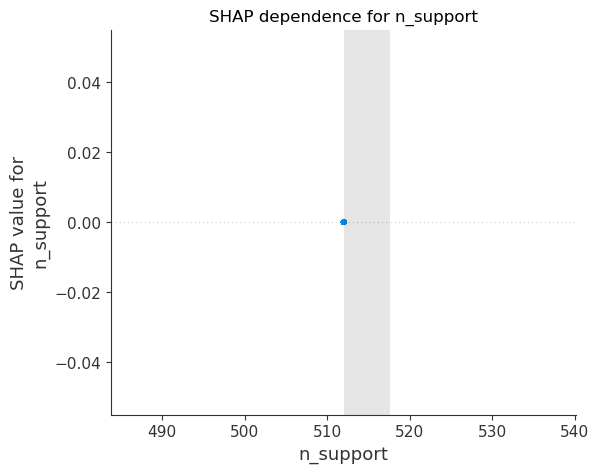

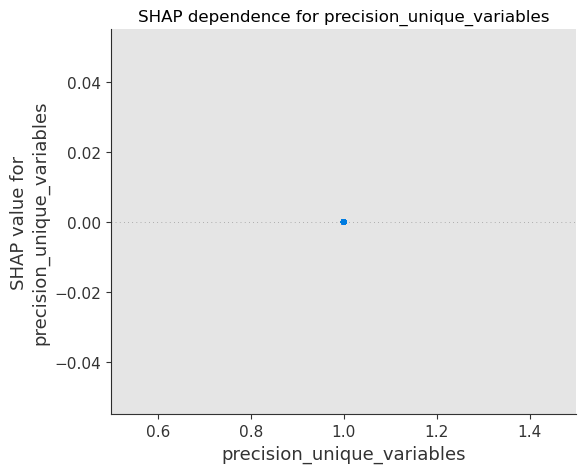

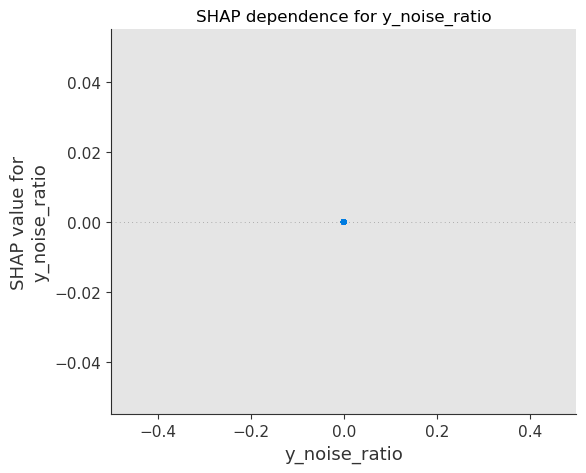

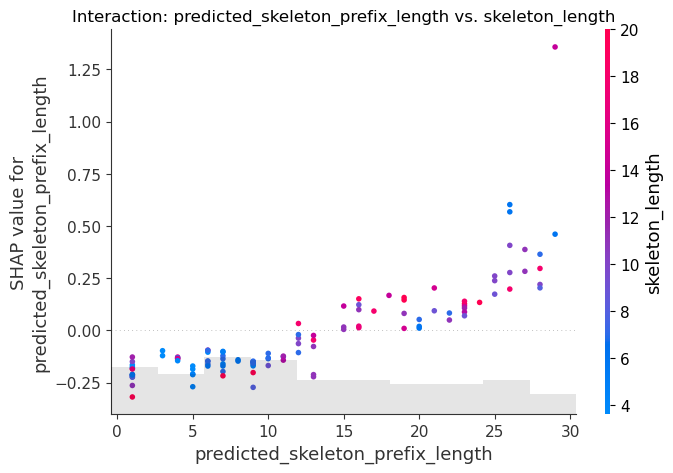

In [43]:
if 'shap_feature_ranking' not in globals():
    raise ValueError('Run the SHAP summary cell before generating dependency plots.')

top_features = shap_feature_ranking['feature'].tolist()
for feature in top_features:
    shap.plots.scatter(shap_values[:, feature], color=shap_values[:, feature], show=False)
    plt.title(f'SHAP dependence for {feature}')
    plt.show()

if len(top_features) >= 2:
    shap.plots.scatter(
        shap_values[:, top_features[0]],
        color=shap_values[:, top_features[1]],
        show=False,
    )
    plt.title(f'Interaction: {top_features[0]} vs. {top_features[1]}')
    plt.show()

In [44]:
assert False

AssertionError: 

In [ ]:
BIN_WIDTH = 1  # number of tokens per bin along the x-axis

metrics = [
    (
        'numeric_recovery_fit',
        f'fNRR $\\%_{{\\mathrm{{FVU}} \\leq \\epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100),
    ),
    (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \\leq \\epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100),
    ),
    (
        'only_approx_log10_fvu_val',
        f'$\\log_{{10}}(\\mathrm{{FVU}}_{{\\mathrm{{FVU}} > \\epsilon_{{32}}}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        naninfmean,
        1,
        (-5, 1),
    ),
    (
        'symbolic_recovery',
        f'SRR $\\%_{{\\hat{{Z}} = Z}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 10),
    ),
    (
        'predicted_log_prob',
        f'$\\mathrm{{Log\\ Probability}} {arrow_notation(objective=1, lower=-np.inf, upper=0)}$',
        naninfmean,
        1,
        (-30, 0),
    ),
    (
        'edit_distance',
        f'$\\mathrm{{Edit\\ Distance}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 20),
    ),
    (
        'skeleton_length_ratio',
        f'$\\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0.5, 2),
    ),
    (
        'n_constants_delta',
        f'$\\mathrm{{Excess\\ Constants}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 3),
    ),
    (
        'f1_score',
        f'$\\mathrm{{F1\\ Score\\ (Expression)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.0, 1),
    ),
    (
        'precision_unique_variables',
        f'$\\mathrm{{Precision\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1),
    ),
    (
        'recall_unique_variables',
        f'$\\mathrm{{Recall\\ (Variables)}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0, 1),
    ),
    (
        'predicted_total_nestedness',
        f'$\\mathrm{{Total\\ Nestedness}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        naninfmean,
        1,
        (0, 1.5),
    ),
]

# https://color.adobe.com/search?q=warm%20blue
models = [
    ('v23.0-3M', 'choices', '#05C7F2'),
    ('v23.0-20M', 'choices', '#05AFF2'),
    # ('v23.0-120M', 'choices', '#0468BF'),
    # ('v23.0-1B', 'choices', '#0339A6'),
    # ('v23.0-7B', 'choices', '#011640'),
    ('pysr', 'niterations', '#c53549'),
]

models = [m for m in models if m[0] in results.keys()]

# test_set = 'fastsrb'
test_set = 'v23_val'

if not models:
    raise ValueError('No matching models found in `results`.')

max_length = 0
for model_name, _, _ in models:
    model_results = results[model_name]['results'].get(test_set, {})
    for run_result in model_results.values():
        lengths = np.asarray(run_result['skeleton_length'], dtype=float)
        lengths = lengths[np.isfinite(lengths)]
        if lengths.size == 0:
            continue
        max_length = max(max_length, int(np.nanmax(lengths)))

if max_length == 0:
    raise ValueError(f'No finite predicted skeleton lengths available for test set {test_set!r}.')

bin_ranges = [(start, min(start + BIN_WIDTH - 1, max_length)) for start in range(1, max_length + 1, BIN_WIDTH)]
bin_centers = np.array([(lo + hi) / 2 for lo, hi in bin_ranges], dtype=float)

COLS = min(4, len(metrics))
ROWS = int(np.ceil(len(metrics) / COLS))
fig, axes = plt.subplots(ROWS, COLS, figsize=(3 * COLS, 2.5 * ROWS), dpi=200)
axes = np.atleast_2d(axes)

y_statistic_name = {
    np.nanmean: 'Mean',
    np.nanmedian: 'Median',
    naninfmean: 'Mean w/o inf',
}

for ax_id, (ax, (y_metric, y_label, y_statistic, y_factor, ylim)) in enumerate(zip(axes.flatten(), metrics)):
    ax: plt.Axes
    for model_name, _, color in models:
        model_results = results[model_name]['results'].get(test_set, {})
        if not model_results:
            continue

        lengths_list, values_list = [], []
        run_result = model_results[max(model_results.keys())]
        # for run_result in model_results.values():
        lengths = np.asarray(run_result['skeleton_length'], dtype=float)
        values = np.asarray(run_result[y_metric], dtype=float)

        valid_mask = np.isfinite(lengths)
        lengths = lengths[valid_mask]
        values = values[valid_mask]

        if y_metric == 'only_approx_log10_fvu_val':
            finite_mask = values != -np.inf
            lengths = lengths[finite_mask]
            values = values[finite_mask]

        finite_values_mask = np.isfinite(values)
        lengths = lengths[finite_values_mask]
        values = values[finite_values_mask]

        if lengths.size == 0:
            continue

        lengths_list.append(lengths)
        values_list.append(values)

        if not lengths_list:
            continue

        lengths = np.concatenate(lengths_list)
        values = np.concatenate(values_list)

        binned_x, binned_med, binned_low, binned_high, binned_counts = [], [], [], [], []
        for (lo, hi), center in zip(bin_ranges, bin_centers):
            bin_mask = (lengths >= lo) & (lengths <= hi)
            if not np.any(bin_mask):
                continue

            bin_values = values[bin_mask]
            bin_values = bin_values[np.isfinite(bin_values)]
            if bin_values.size == 0:
                continue

            y_ci = bootstrapped_metric_ci(bin_values, y_statistic, n=1e3, interval=0.95)
            binned_x.append(center)
            binned_med.append(y_ci[0] * y_factor)
            binned_low.append(y_ci[1] * y_factor)
            binned_high.append(y_ci[2] * y_factor)
            binned_counts.append(bin_values.size)

        if not binned_x:
            continue

        binned_x = np.array(binned_x)
        order = np.argsort(binned_x)
        binned_x = binned_x[order]
        binned_med = np.array(binned_med)[order]
        binned_low = np.array(binned_low)[order]
        binned_high = np.array(binned_high)[order]
        binned_counts = np.array(binned_counts)[order]

        mask_minimum_counts = binned_counts >= 5

        ax.errorbar(
            binned_x[mask_minimum_counts],
            binned_med[mask_minimum_counts],
            yerr=[binned_med[mask_minimum_counts] - binned_low[mask_minimum_counts], binned_high[mask_minimum_counts] - binned_med[mask_minimum_counts]],
            fmt='.',
            label=model_name,
            color=color,
            capsize=1,
            elinewidth=1,
        )
        ax.fill_between(binned_x[mask_minimum_counts], binned_low[mask_minimum_counts], binned_high[mask_minimum_counts], color=color, alpha=0.1)

    if ylim[0] is not None and ylim[1] is not None:
        ax.set_ylim(ylim)

    ax.set_title(y_label, fontsize=11)
    ax.grid(alpha=0.5)

    x_ticks_fontsize = 10 if ax_id // COLS == ROWS - 1 else 8
    xticks = np.arange(0, max_length + 1, 4)
    xticklabels = [str(int(x)) for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=x_ticks_fontsize)

    ax.set_xlim(bin_centers[0] - BIN_WIDTH / 2, bin_centers[-1] + BIN_WIDTH / 2)

    if ax_id // COLS == ROWS - 1:
        ax.set_xlabel('Predicted Expression Length (tokens)')

    ax.annotate(
        y_statistic_name.get(y_statistic, y_statistic.__name__),
        xy=(0.02, 0.97),
        xycoords='axes fraction',
        fontsize=8,
        color='k',
        ha='left',
        va='top',
        alpha=0.4,
    )

for ax in axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=9)
        break

for ax in axes.flatten()[len(metrics):]:
    ax.axis('off')

fig.tight_layout(w_pad=1, h_pad=2)

ValueError: No finite predicted skeleton lengths available for test set 'v23_val'.